In [174]:
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from JSAnimation import IPython_display
import copy


class my_gridworld_2():
    
    def __init__(self,**args):
                
        ### initialize global containers and variables
        # initialize containers for grid, hazard locations, agent and goal locations, etc.,
        self.grid = []
        self.hazards = []
        self.agent = []
        self.goal = []
        self.training_episodes_history_v1 = []
        self.training_episodes_history_v2 = []
        self.training_start_schedule = []  # container for holding starting positions for traininig
        self.testing_start_schedule = []   # container for holding starting psoitions for testing
        self.training_reward_v1 = []
        self.training_reward_v2 = []
        
        # initialize global variables e.g., height and width of gridworld, hazard penalty value
        self.width = 0
        self.height = 0
        self.hazard_reward = 0
        self.goal_reward = 0
        self.standard_reward = -1
        self.num_episodes = 0
        self.training_episodes = 0
        self.testing_epislodes = 0
        
        # setup world
        world_name = ''
        if "world" in args:
            # get correct hazard list        
            csvname = []
            if args["world"] == 'small demo':
                csvname = 'RL_datasets/small_demo_hazards.csv'
                self.width = 5
                self.height = 4
                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                # initialize agent location
                self.agent = [0,0]   # initial location agent
                world_name = 'small_demo'
                
            if args["world"] == 'big random':
                csvname = 'RL_datasets/big_random_hazards.csv'
                self.width = 20
                self.height = 10
                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                # initialize agent location
                self.agent = [0,0]   # initial location agent
                world_name = 'big_random'
                    
            if args["world"] == 'small maze':
                csvname = 'RL_datasets/small_maze_hazards.csv'
                self.width = 13
                self.height = 11
                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                # initialize agent location
                self.agent = [self.height-2, 0]   # initial location agent
                world_name = 'small_maze'

            if args["world"] == 'big maze':
                csvname = 'RL_datasets/big_maze_hazards.csv'
                self.width = 41
                self.height = 15
                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                # initialize agent location
                self.agent = [self.height-2, 0]   # initial location agent
                world_name = 'big_maze'
                
            # setup grid
            self.grid = np.zeros((self.height,self.width))
            
            # load in preset hazard locations from csv
            self.hazards = pd.read_csv(csvname,header = None)
            
            # initialize hazards locations
            temp = []
            for i in range(len(self.hazards)):
                block = list(self.hazards.iloc[i])
                self.grid[block[0]][block[1]] = 1   
                temp.append(block)

            # initialize goal location
            self.hazards = temp
                
        ### initialize state index, Q matrix, and action choices ###
        # index states for Q matrix
        self.states = []
        for i in range(self.height):
            for j in range(self.width):
                block = [i,j]
                self.states.append(str(i) + str(j))
        
        # setup hazard reward value
        self.hazard_reward = -self.width*self.height 
        if 'hazard_reward' in args:
            self.hazard_reward = args['hazard_reward'] 
        
        # initialize action choices
        self.action_choices = [[-1,0],[1,0],[0,-1],[0,1]]
        
        # initialize Q^* matrix
        self.Q_star_v1 = np.zeros((self.width*self.height,len(self.action_choices)))
        self.Q_star_v2 = np.zeros((self.width*self.height,len(self.action_choices)))

        ### create custom colormap for gridworld plotting ###
        vmax = 3.0
        self.my_cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, [0.9,0.9,0.9]),
                                                        (1 / vmax, [1,0.5,0]),
                                                        (2 / vmax, 'lime'),
                                                        (3 / vmax, 'blue')]
                                                        )
        
        ### load preset random training start schedule or create new one ###
        train_csvname = 'RL_datasets/' +  world_name + '_training_start_schedule.csv'
        test_csvname = 'RL_datasets/' + world_name + '_testing_start_schedule.csv'
        if 'training_episodes' in args:
            self.training_episodes = args['training_episodes']
            
            # make new training start schedule
            self.training_start_schedule = self.make_start_schedule(episodes = self.training_episodes)
        
            # save new training start schedule for future use
            b = pd.DataFrame(self.training_start_schedule)
            b.to_csv(train_csvname,header = None,index = False)

        else:    # load pre-set random starting positions
            # preset number of training episodes value
            self.training_episodes = 200
            
            # load in preset random training starting positions
            temp = pd.read_csv(train_csvname,header = None)
            
            self.training_start_schedule = []
            for i in range(len(temp)):
                block = list(temp.iloc[i])
                self.training_start_schedule.append(block)
                
        ### load preset random training start schedule or create new one ###
        if 'testing_episodes' in args:
            self.testing_episodes = args['testing_episodes']
            
            # make new training starting schedule
            self.testing_start_schedule = self.make_start_schedule(episodes = self.testing_episodes)
        
            # save new training start schedule for future use
            b = pd.DataFrame(self.testing_start_schedule)
            b.to_csv(test_csvname,header = None,index = False)
            
        else:    # load pre-set random starting positions
            # preset number of training episodes value
            self.testing_episodes = 100
            
            # load in preset random training starting positions
            temp = pd.read_csv(test_csvname,header = None)
            
            self.testing_start_schedule = []
            for i in range(len(temp)):
                block = list(temp.iloc[i])
                self.testing_start_schedule.append(block)
        
    ### world coloring function ###
    def color_gridworld(self,ax):
        # copy grid for plotting, add agent and goal location
        p_grid = copy.deepcopy(self.grid)
        p_grid[self.goal[0]][self.goal[1]] = 2   
        p_grid[self.agent[0]][self.agent[1]] = 3   
        
        # plot gridworld
        ax.pcolormesh(p_grid,edgecolors = 'k',linewidth = 0.01,cmap = self.my_cmap)

        # clean up plot
        ax.axis('off')
        ax.set_xlim(-0.1,self.width + 1.1);
        ax.set_ylim(-0.1,self.height + 1.1);        
 
    ### create starting schedule - starting position of each episode of training or testing ###
    def make_start_schedule(self,**args):
        num_episodes = args['episodes']
        start_schedule = []
        
        # create schedule of random starting positions for each episode
        if 'start_schedule' not in args or ('start_schedule' in args and args['start_schedule'] == 'random'):
            for i in range(num_episodes):
                loc = [np.random.randint(self.height),np.random.randint(self.width)]
                start_schedule.append(loc)
                
        # create exhaustive starting schedule - cycle through states sequentially
        if 'start_schedule' in args and args['start_schedule'] == 'exhaustive':
            i = 0
            while i <= num_episodes:
                for j in range(self.width):
                    for k in range(self.height):
                        loc = [j,k]
                        start_schedule.append(loc)
                        i+=1
        
        return start_schedule
                        
    ################## q-learning functions ##################
    def get_reward(self,location):
        r_k = 0

        # if new state is goal set reward of 0
        if location == self.goal:
            r_k = self.goal_reward
        elif location in self.hazards:
            r_k = self.hazard_reward
        else:  # standard non-hazard square
            r_k = self.standard_reward
        return r_k          
    
    ### Q-learning function - version 1 - random actions ###
    def qlearn_v1(self,**args):
        ### set basic parameters controlling training regiment ###
        # default parameters for the qlearning 
        gamma = 0.8                            # short term / long term learning tradeoff param
        max_steps = 5*self.width*self.height  # maximum number of steps per episode

        # change these default parameters if user requests
        num_episodes = self.training_episodes
        if "gamma" in args:
            gamma = args['gamma']
        if 'max_steps' in args:
            max_steps = args['max_steps']    
        
        ### start main Q-learning loop ###
        self.training_episodes_history_v1 = {}
        self.training_reward_v1 = []
        self.Q_star_v1 = np.zeros((self.width*self.height,len(self.action_choices)))
        for n in range(num_episodes):    
            # pick this episode's starting position
            loc = self.training_start_schedule[n]

            # update Q matrix while loc != goal
            episode_history = []      # container for storing this episode's journey
            episode_history.append(loc)
            total_episode_reward = 0
            for step in range(max_steps):    
                ### if you reach the goal end current episode immediately
                if loc == self.goal:
                    break
                    
                ### choose next action - left = 0, right = 1, up = 2, down = 3 --> if this leads you outside the gridworld you don't move ###
                # pick random actions
                k = np.random.randint(len(self.action_choices))  
                
                # update old location
                loc2 = [sum(x) for x in zip(loc, self.action_choices[k])] 
                ind_old = self.states.index(str(loc[0]) + str(loc[1]))

                # if new state is outside of boundaries of grid world do not move
                if loc2[0] > self.height-1 or loc2[0] < 0 or loc2[1] > self.width-1 or loc2[1] < 0:  
                    loc2 = loc
                    
                ### update episode history container
                episode_history.append(loc2)
                    
                ### recieve reward     
                r_k = self.get_reward(loc2)
                total_episode_reward += r_k
                
                ### Update Q function
                ind_new = self.states.index(str(loc2[0]) + str(loc2[1]))
                self.Q_star_v1[ind_old,k] = r_k + gamma*max(self.Q_star_v1[ind_new,:])
                    
                ### update current location of agent to one we just moved too (or stay still if grid world boundary met)
                self.agent = loc2
                loc = loc2
                
            ### store this episode's history
            self.training_episodes_history_v1[str(n)] = episode_history
            self.training_reward_v1.append(total_episode_reward)

        print 'q-learning version 1 algorithm complete'

    ### Q-learning function - version 2 - with exploration vs exploitation chosen actions ###
    def qlearn_v2(self,**args):
        ### set basic parameters controlling training regiment ###
        # default parameters for the qlearning 
        gamma = 0.8                           # short term / long term learning tradeoff param
        explore_exploit_param = 0.8           # exploration exploitation param tradeoff (with probability less than this param action chosen by exploitation)
        max_steps = 5*self.width*self.height  # maximum number of steps per episode

        # change these default parameters if user requests
        num_episodes = self.training_episodes
        if "gamma" in args:
            gamma = args['gamma']
        if 'max_steps' in args:
            max_steps = args['max_steps']  
        if 'explore_exploit_param' in args:
            explore_exploit_param = args['explore_exploit_param']

        ### start main Q-learning loop ###
        self.training_episodes_history_v2 = {}
        self.training_reward_v2 = []
        self.Q_star_v2 = np.zeros((self.width*self.height,len(self.action_choices)))
        for n in range(num_episodes):    
            # pick this episode's starting position
            loc = self.training_start_schedule[n]
            
            # update Q matrix while loc != goal
            episode_history = []      # container for storing this episode's journey
            episode_history.append(loc)
            total_episode_reward = 0
            for step in range(max_steps):    
                ### if you reach the goal end current episode immediately
                if loc == self.goal:
                    break
                    
                ### choose next action - left = 0, right = 1, up = 2, down = 3 --> if this leads you outside the gridworld you don't move ###
                k = 0
                # choose action based on max
                r = np.random.rand(1)
                if r < explore_exploit_param:
                    ind_old = self.states.index(str(loc[0]) + str(loc[1]))
                    k = np.argmax(self.Q_star_v2[ind_old,:])
                else:
                    # pick random actions
                    k = np.random.randint(len(self.action_choices))
                
                # update old location
                loc2 = [sum(x) for x in zip(loc, self.action_choices[k])] 
                ind_old = self.states.index(str(loc[0]) + str(loc[1]))

                # if new state is outside of boundaries of grid world do not move
                if loc2[0] > self.height-1 or loc2[0] < 0 or loc2[1] > self.width-1 or loc2[1] < 0:  
                    loc2 = loc
                    
                ### update episode history container
                episode_history.append(loc2)
                    
                ### recieve reward     
                r_k = self.get_reward(loc2)
                total_episode_reward += r_k
                
                ### Update Q function
                ind_new = self.states.index(str(loc2[0]) + str(loc2[1]))
                self.Q_star_v2[ind_old,k] = r_k + gamma*max(self.Q_star_v2[ind_new,:])
                    
                ### update current location of agent to one we just moved too (or stay still if grid world boundary met)
                self.agent = loc2
                loc = loc2
                
            ### store this episode's history
            self.training_episodes_history_v2[str(n)] = episode_history
            self.training_reward_v2.append(total_episode_reward)
        print 'q-learning version 2 algorithm complete'
            
    ################## animation functions ##################
    ### animate training episode from one version of q-learning ###
    def animate_single_version_training_episodes(self,episodes):
        # initialize figure
        fig = plt.figure(figsize = (10,3))
        axs = []
        for i in range(len(episodes)):
            ax = fig.add_subplot(1,len(episodes),i+1)
            axs.append(ax)
            
        if len(episodes) == 1:
            axs = np.array(axs)

        # make a copy of the original gridworld - set at initialization
        gridworld_orig = self.grid.copy()
        
        # compute maximum length of episodes animated
        max_len = 0
        for key in episodes:
            l = len(self.training_episodes_history_v1[str(key)])
            if l > max_len:
                max_len = l

        # loop over the episode histories and plot the results
        def show_episode(step):
            # loop over subplots and plot current step of each episode history
            artist = fig

            for k in range(len(axs)):
                ax = axs[k]
                
                # take correct episode
                episode_num = episodes[k]
                current_episode = self.training_episodes_history_v1[str(episode_num)]
                                
                # define new location of agent
                loc = current_episode[min(step,len(current_episode)-1)]
                self.agent = loc
                
                # color gridworld for this episode and step
                self.color_gridworld(ax)
                ax.set_title('episode = ' + str(episode_num + 1))
            return artist,
           
        # create animation object
        anim = animation.FuncAnimation(fig, show_episode,frames=min(100,max_len), interval=min(100,max_len), blit=True)
        
        # set frames per second in animation
        IPython_display.anim_to_html(anim,fps = min(100,max_len)/float(5))
    
        return(anim)
    
    ### animate training episode from one version of q-learning ###
    def compare_v1v2_training_episode(self,episode_to_compare):
        # initialize figure
        episode_to_compare = episode_to_compare - 1
        fig = plt.figure(figsize = (10,3))
        axs = []
        for i in range(2):
            ax = fig.add_subplot(1,2,i+1)
            axs.append(ax)

        # make a copy of the original gridworld - set at initialization
        gridworld_orig = self.grid.copy()
        
        # compute maximum length of episodes animated
        max_len = 0
        key = episode_to_compare
        L1 = len(self.training_episodes_history_v1[str(key)])
        L2 = len(self.training_episodes_history_v2[str(key)])
        max_len = max(L1,L2)
        
        # loop over the episode histories and plot the results
        rewards =  np.zeros((2,1))
        def show_episode(step):
            # loop over subplots and plot current step of each episode history
            artist = fig
            for k in range(len(axs)):
                ax = axs[k]
                
                # take correct episode
                current_episode = 0
                if k == 0:
                    current_episode = self.training_episodes_history_v1[str(key)]
                else:
                    current_episode = self.training_episodes_history_v2[str(key)]
                        
                # define new location of agent
                loc = current_episode[min(step,len(current_episode)-1)]
                self.agent = loc
                
                # recieve reward     
                r_k = self.get_reward(loc)
                rewards[k] += r_k
                
                # color gridworld for this episode and step
                self.color_gridworld(ax)
#                 ax.set_title('total reward = ' + str(rewards[k][0]),fontsize = 18)                
            return artist,
           
        # create animation object
        anim = animation.FuncAnimation(fig, show_episode,frames=min(100,max_len), interval=min(100,max_len), blit=True)
        
        # set frames per second in animation
        IPython_display.anim_to_html(anim,fps = min(100,max_len)/float(5))
    
        return(anim)
    
    ### a simple plot comparing qlearning v1 and v2 training costs ###
    def compare_v1v2_training_rewards(self):
        # initialize figure
        fig = plt.figure(figsize = (4,4))
        
        # plot each reward history
        plt.plot(self.training_reward_v1,color = 'b',linewidth = 1.5)
        plt.plot(self.training_reward_v2,color = 'r',linewidth = 1.5)
        
        # clean up panel
        plt.xlabel('episode')
        plt.ylabel('total reward')

q-learning version 1 algorithm complete
q-learning version 2 algorithm complete


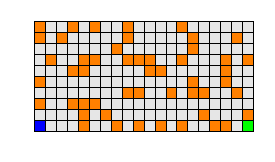

In [175]:
%matplotlib inline
# generate instance of gridworld
test = my_gridworld_2(world = 'big random',hazard_reward = -1)

# create figure
fig1 = plt.figure(figsize = (3,3))
ax1 = fig1.add_subplot(111, aspect='equal')

# show us the grid
test.color_gridworld(ax1)

# run version 1
test.qlearn_v1()

# run version 2
test.qlearn_v2()


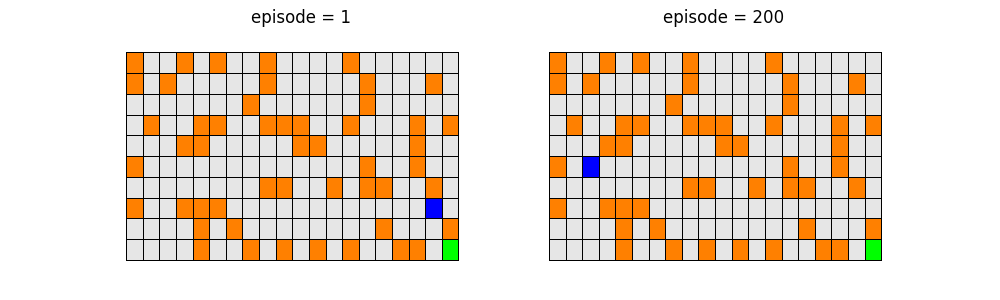
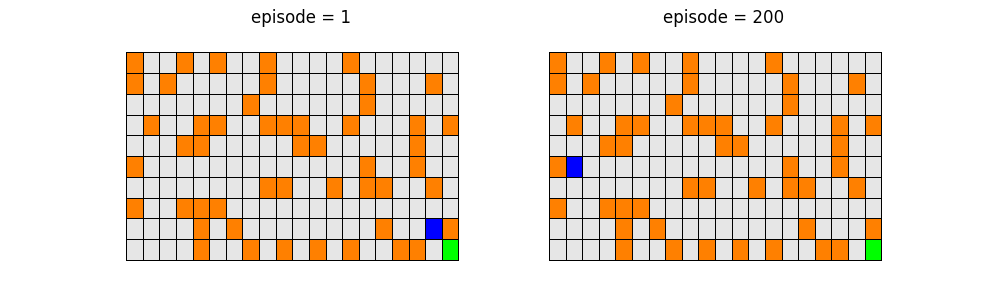
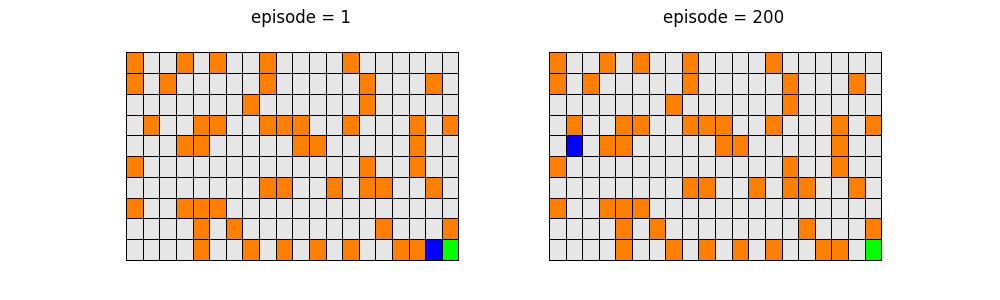
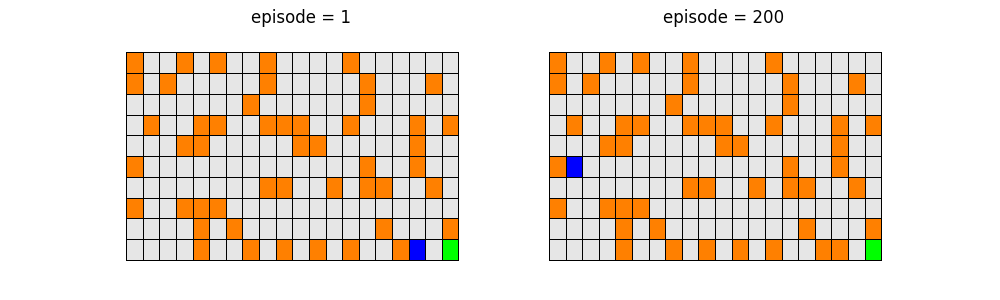
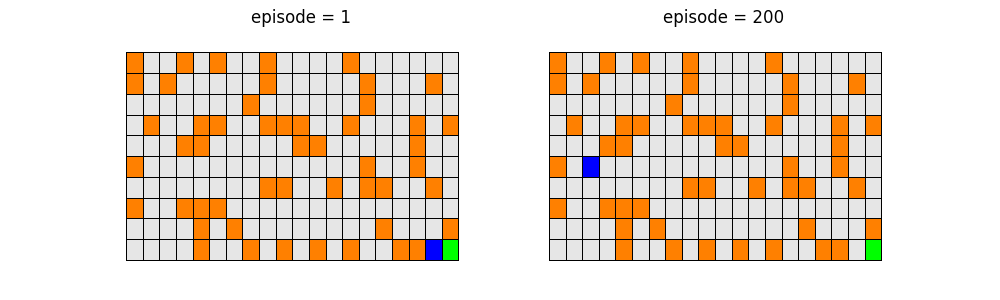
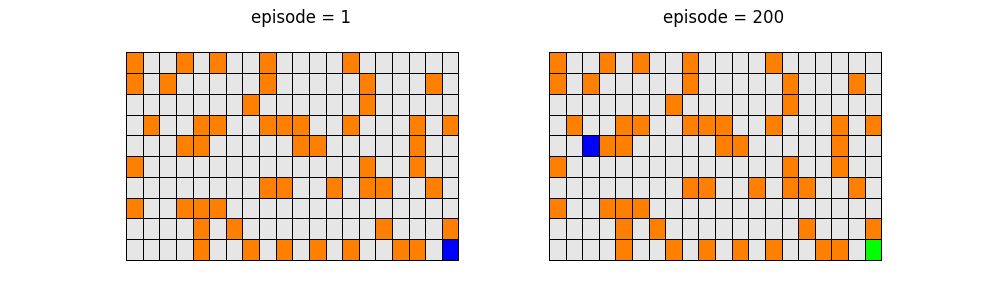
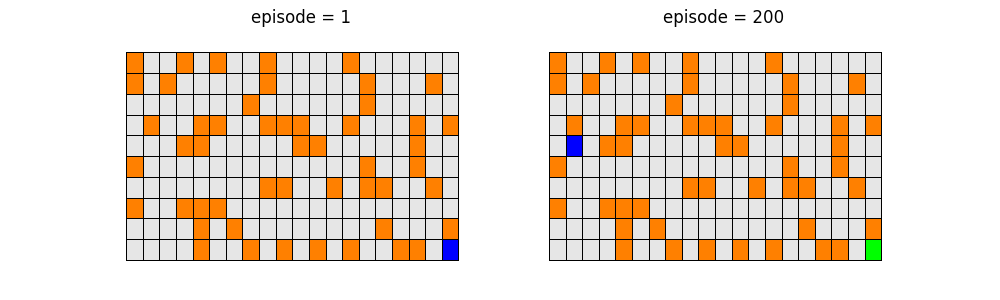
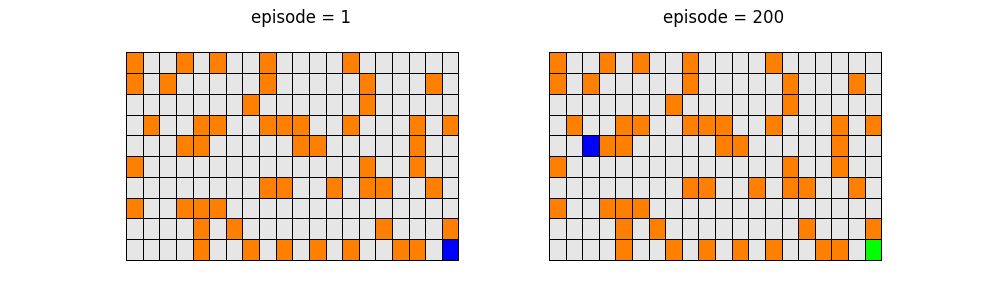
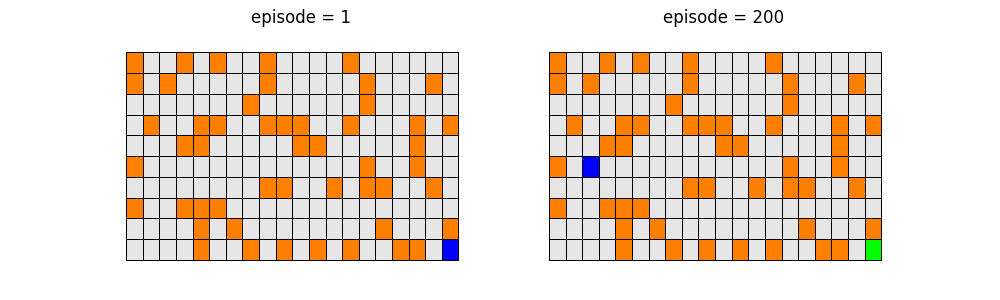
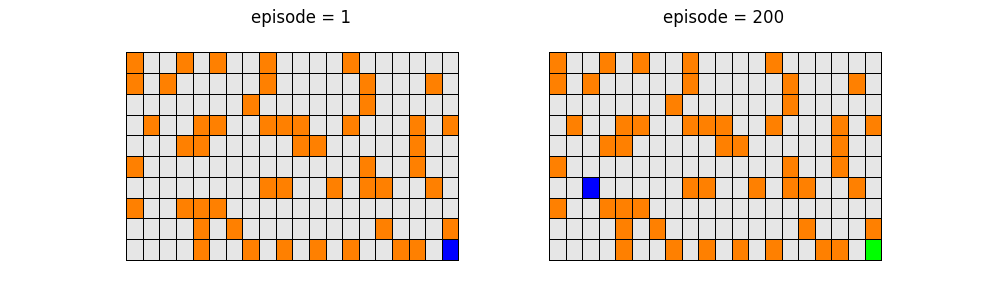
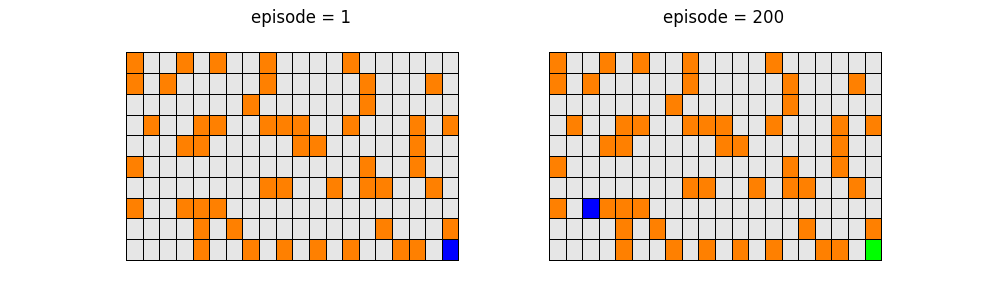
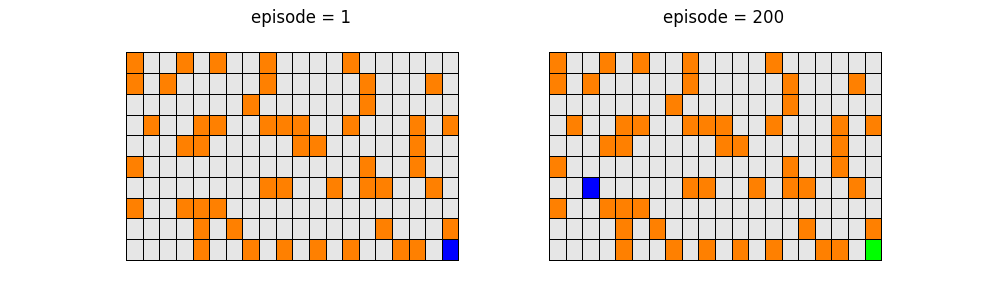
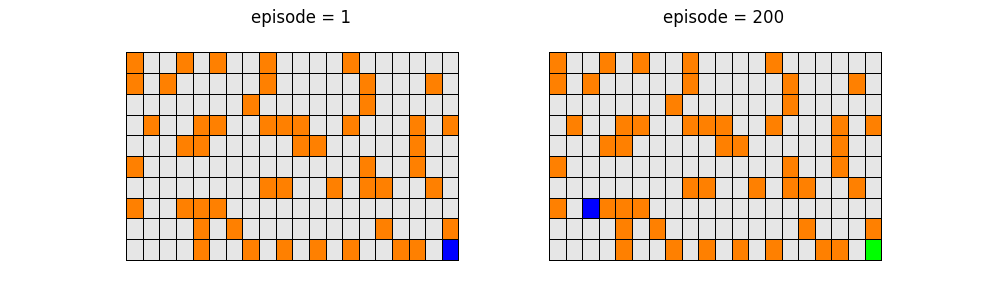
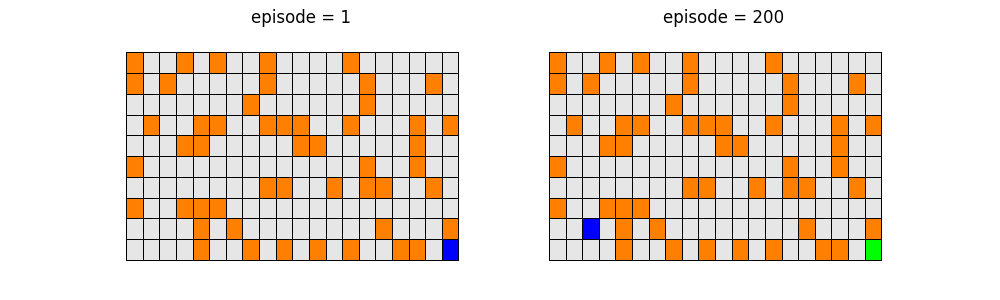
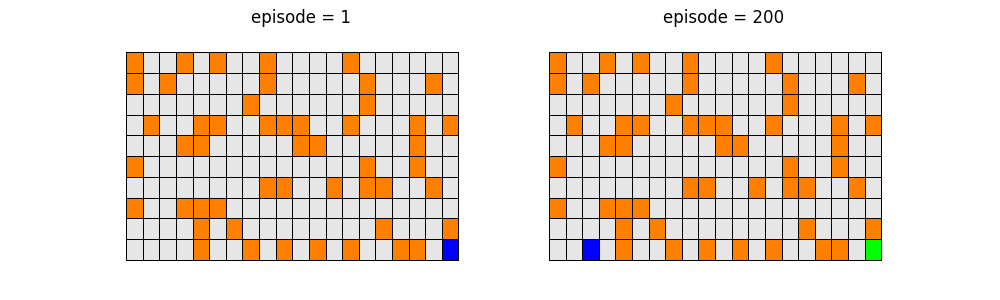
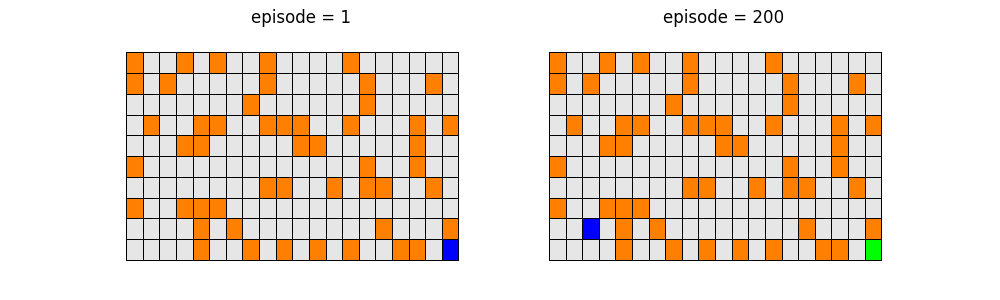
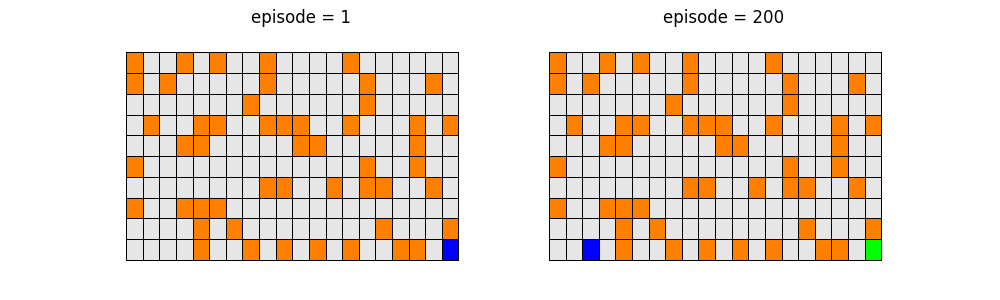
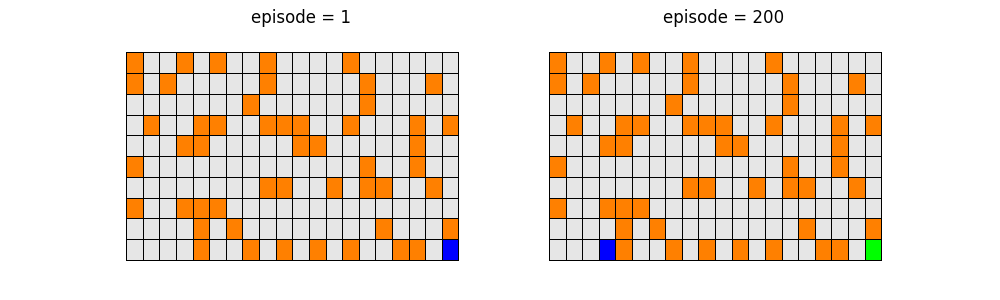
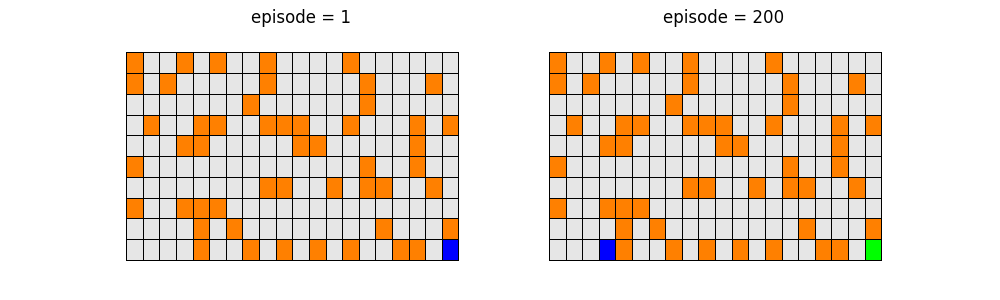
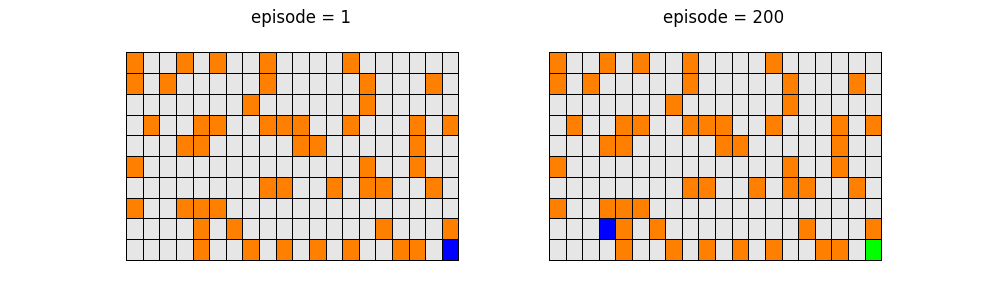
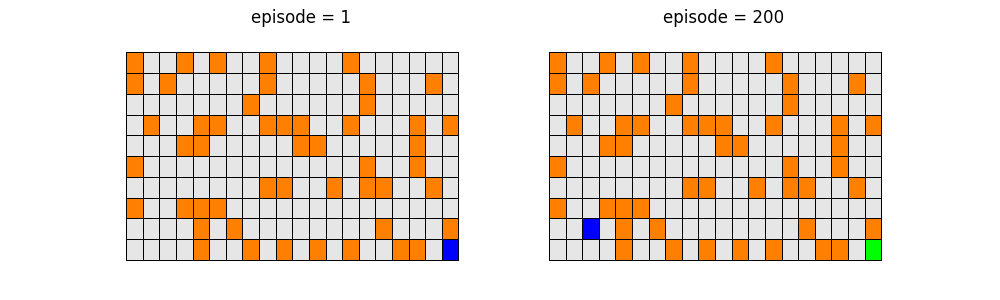
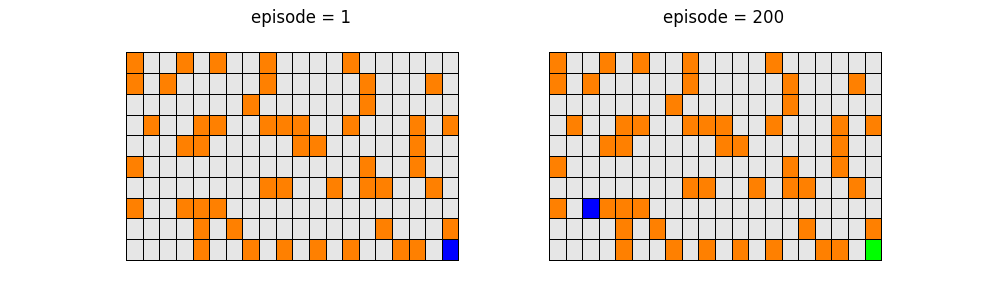
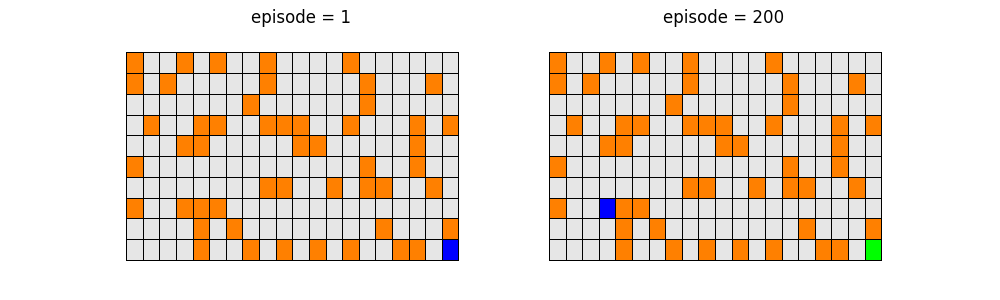
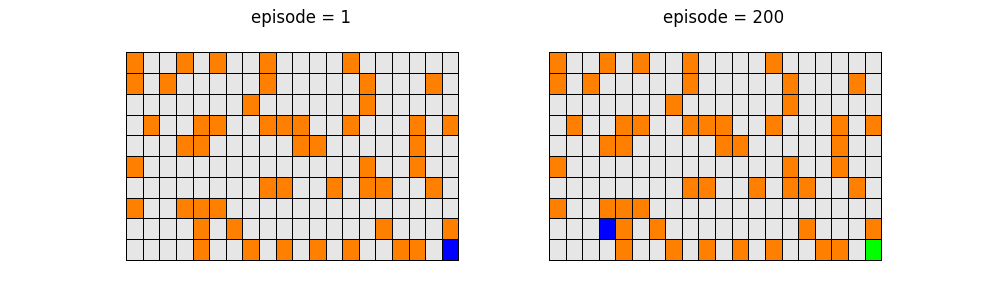
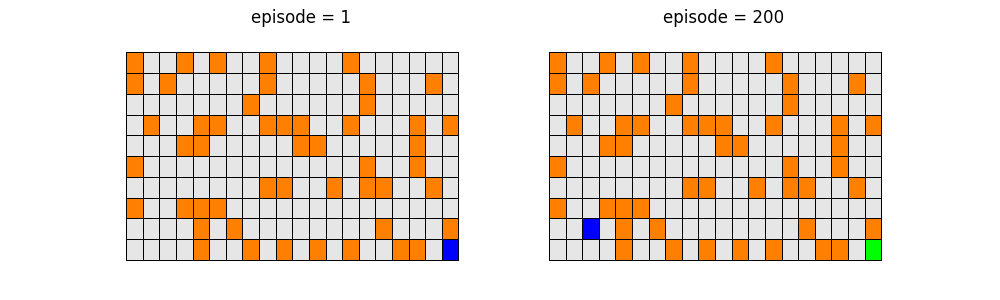
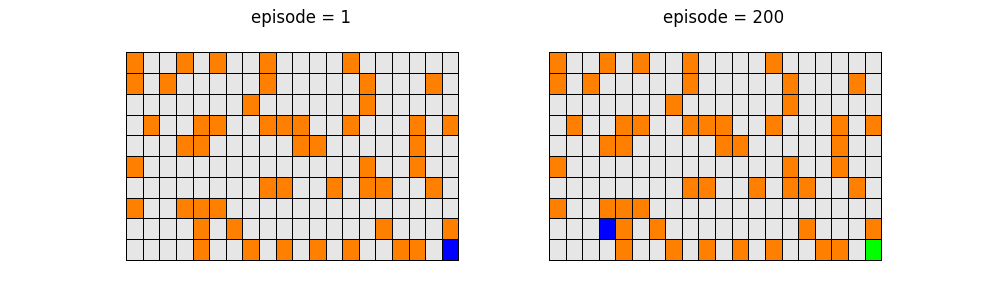
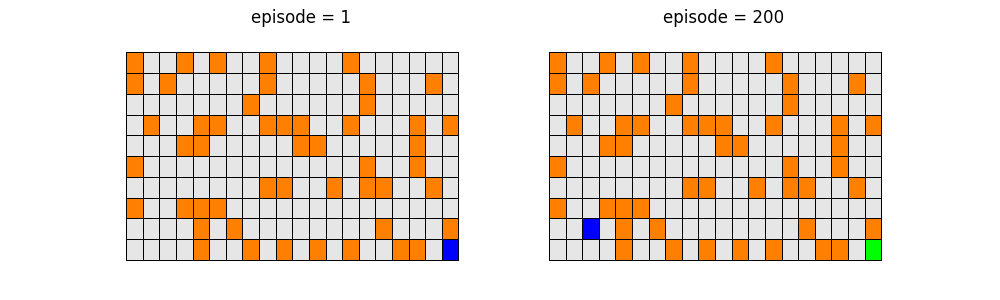
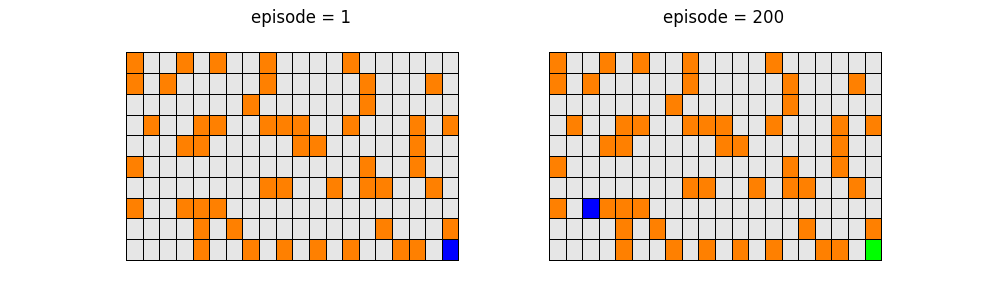
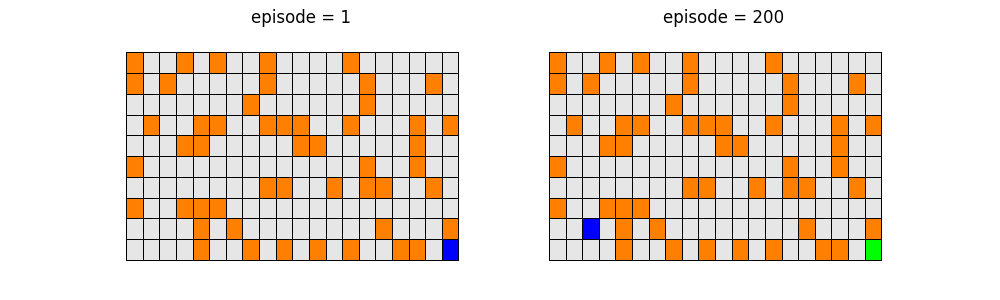
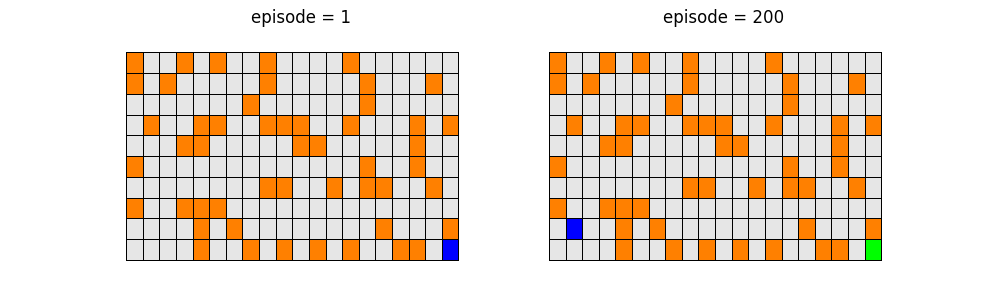
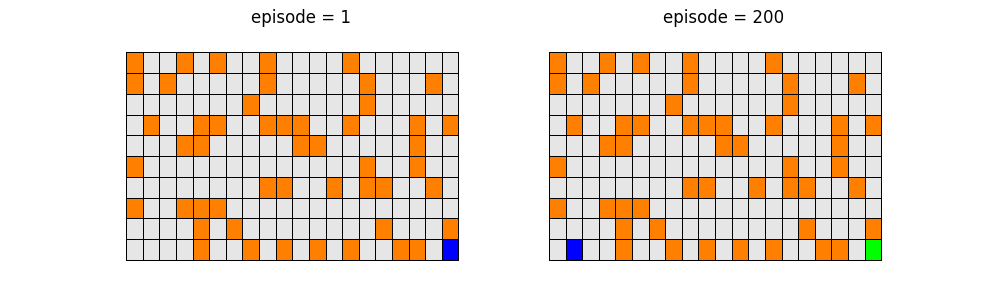
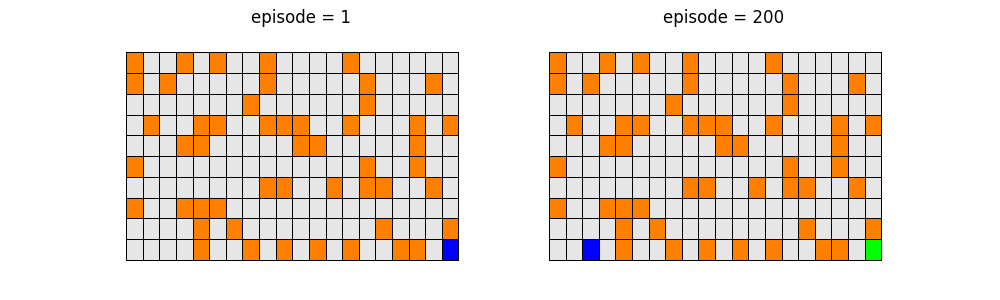
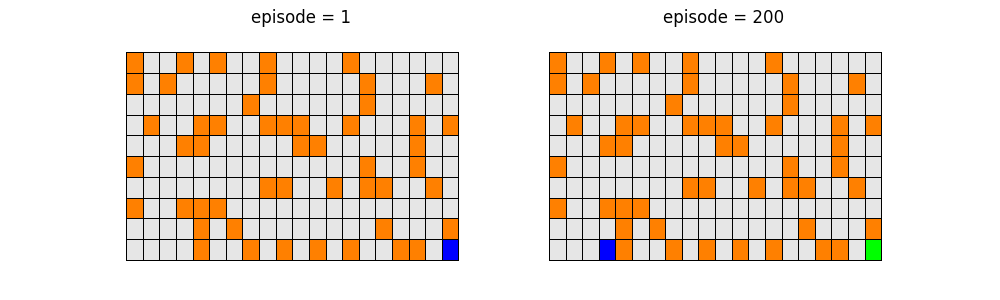
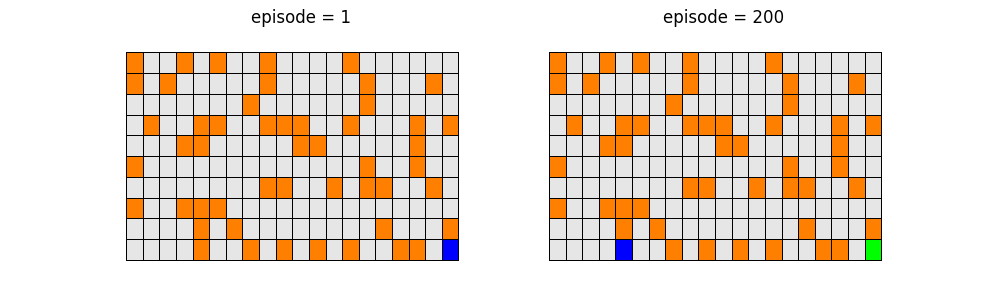
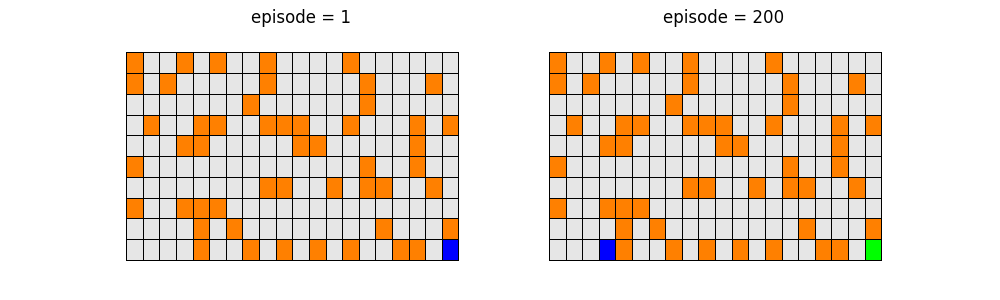
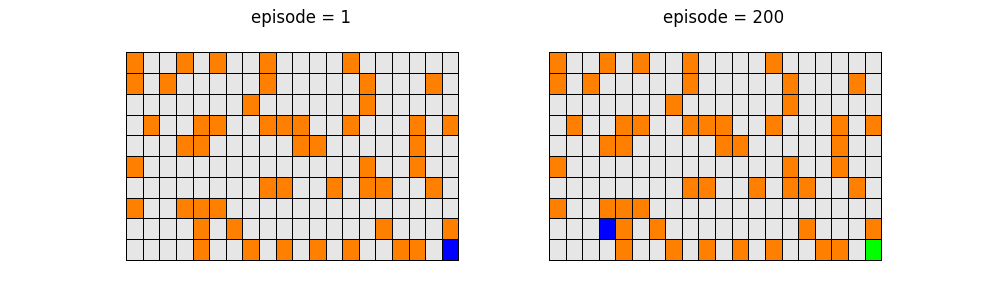
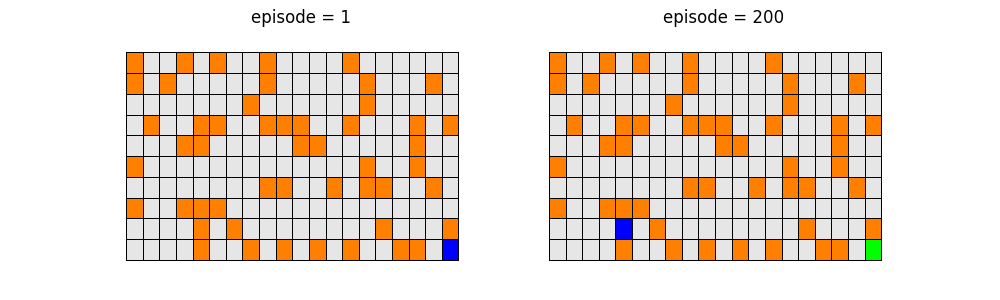
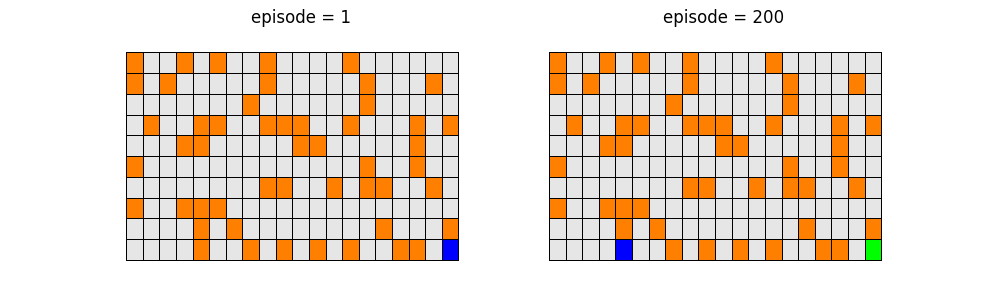
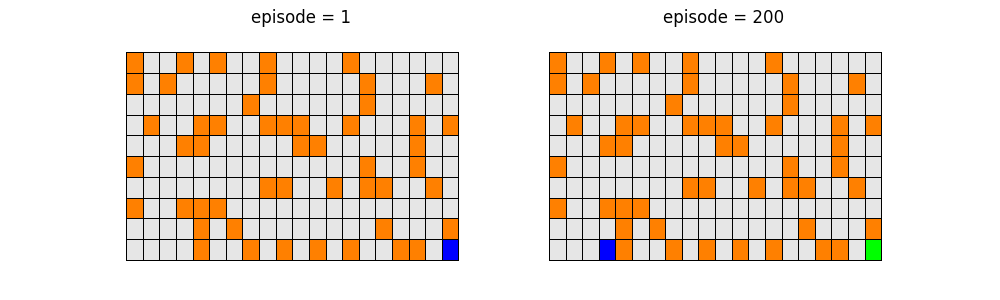
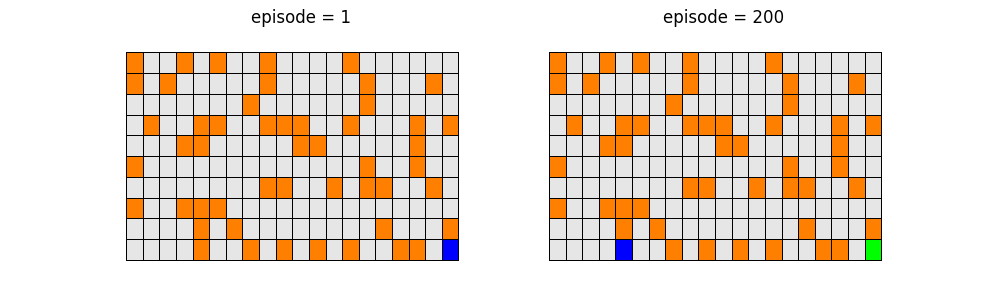
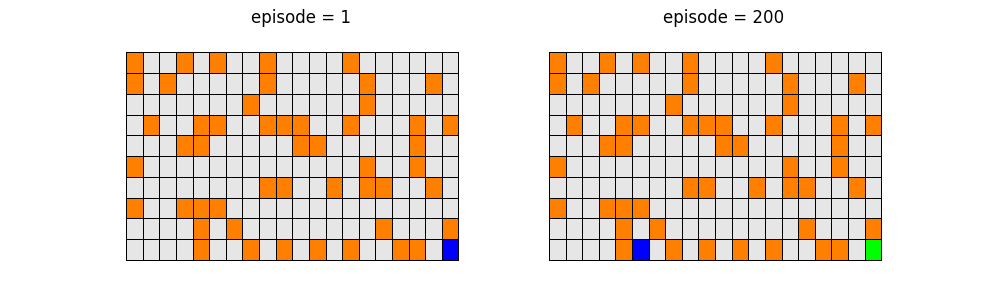
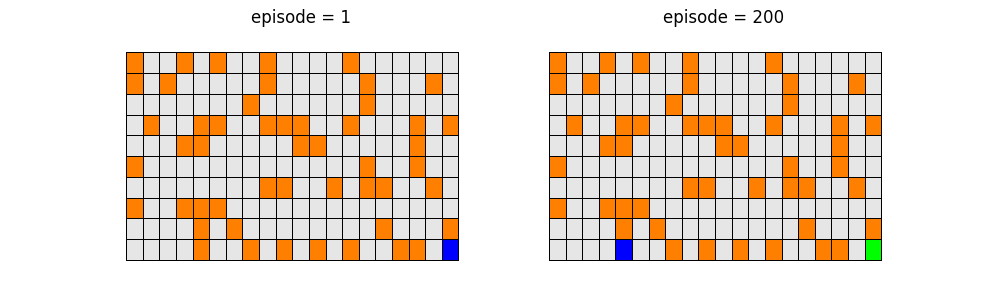
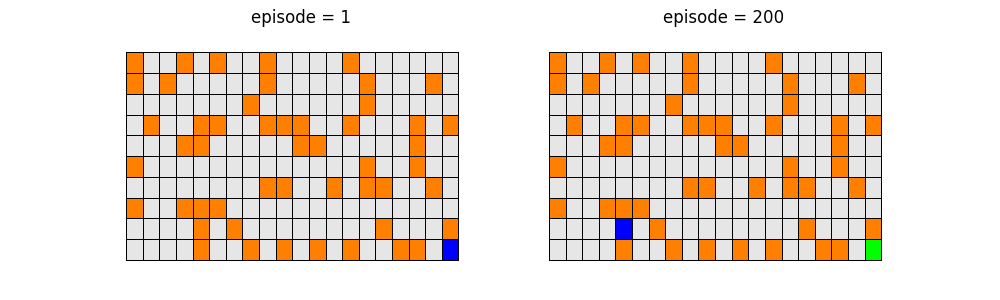
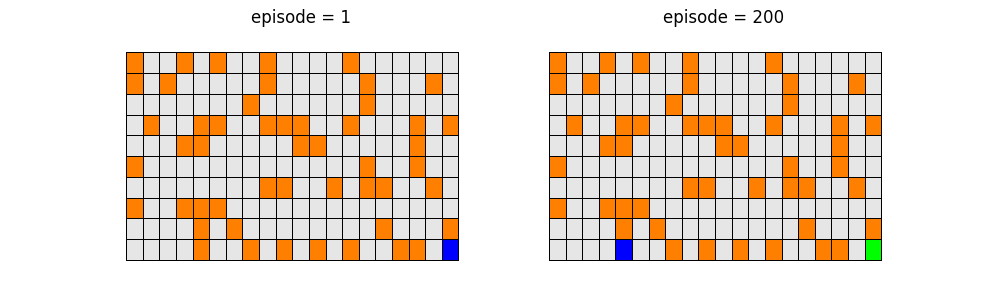
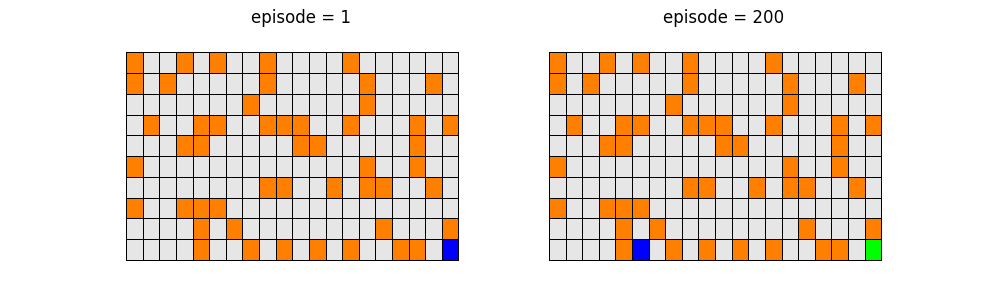
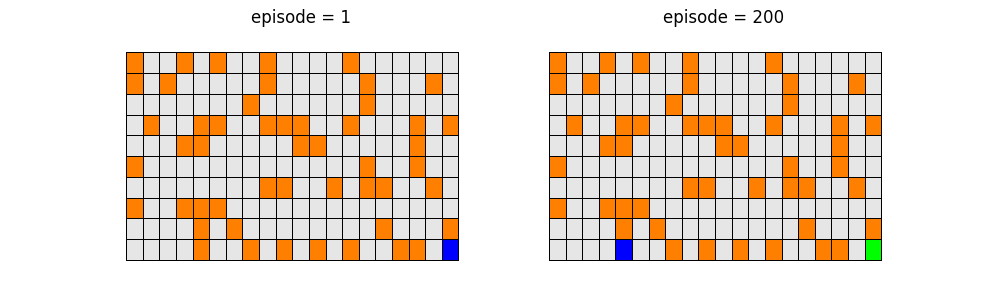
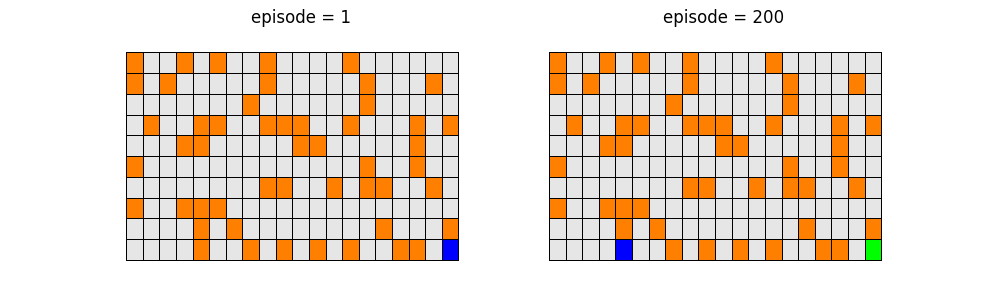
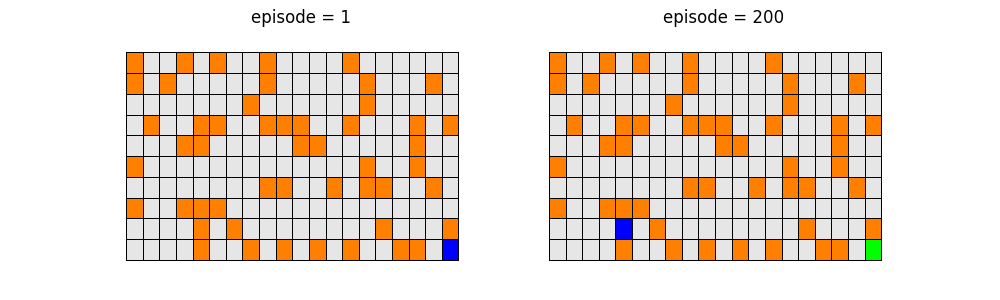
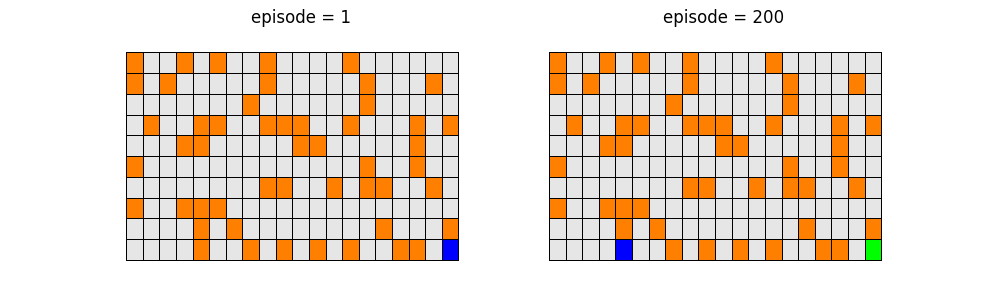
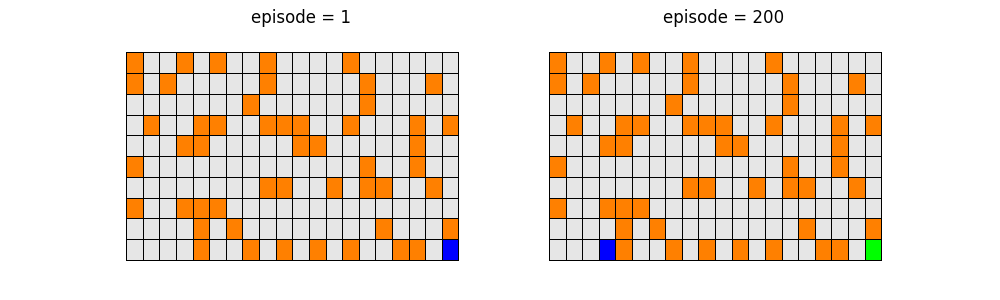
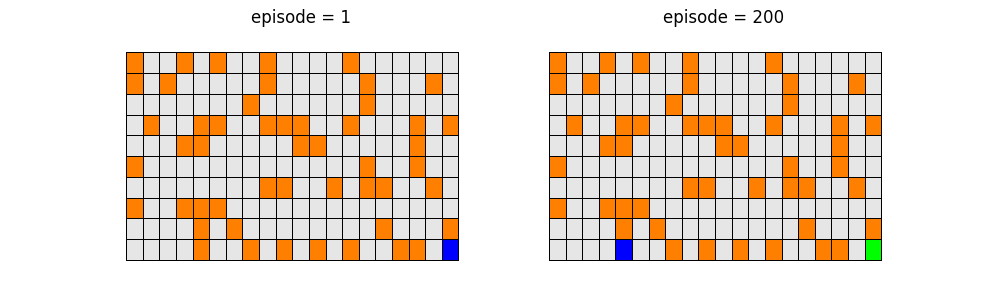
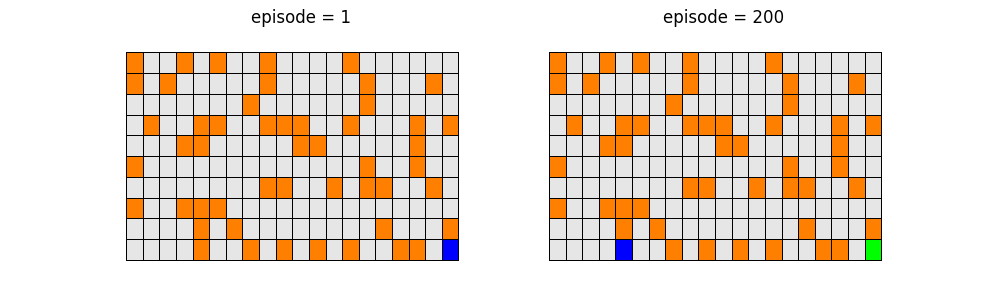
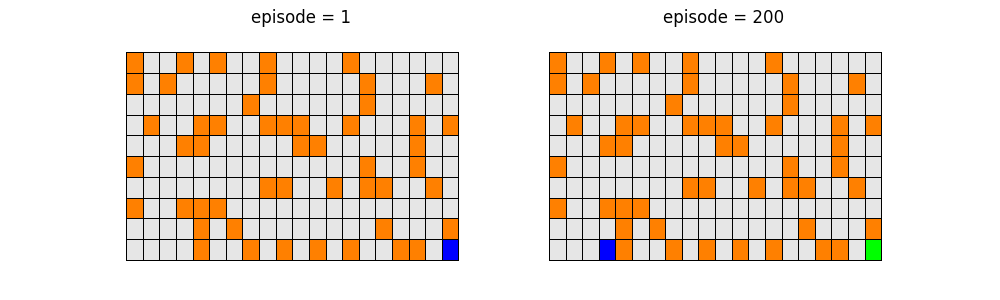
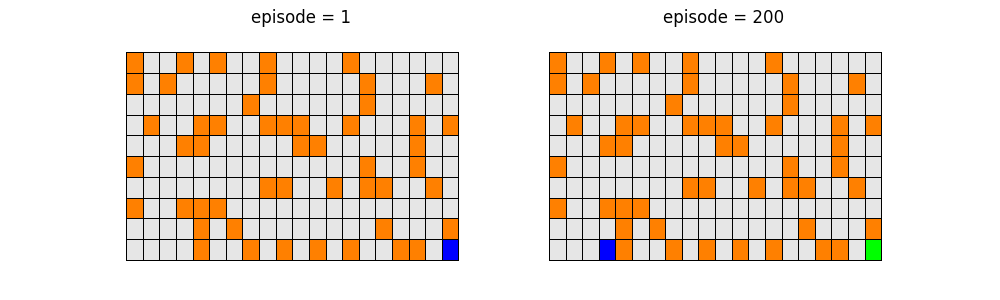
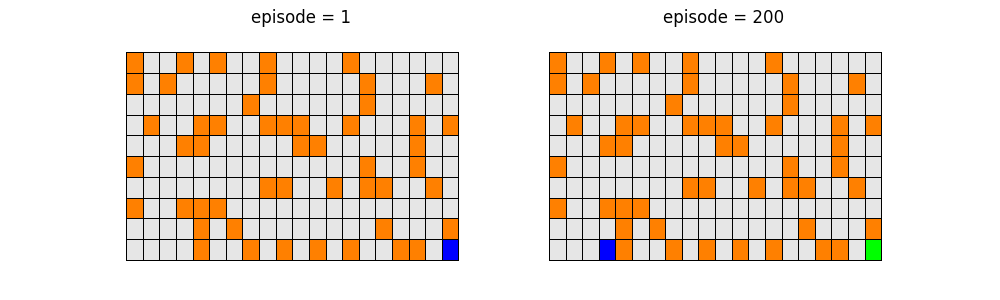
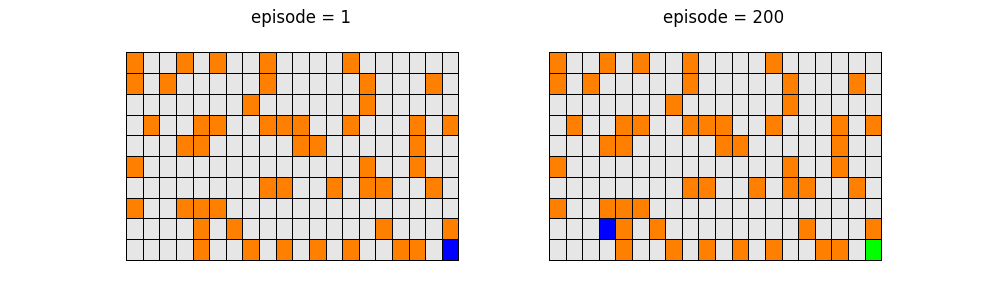
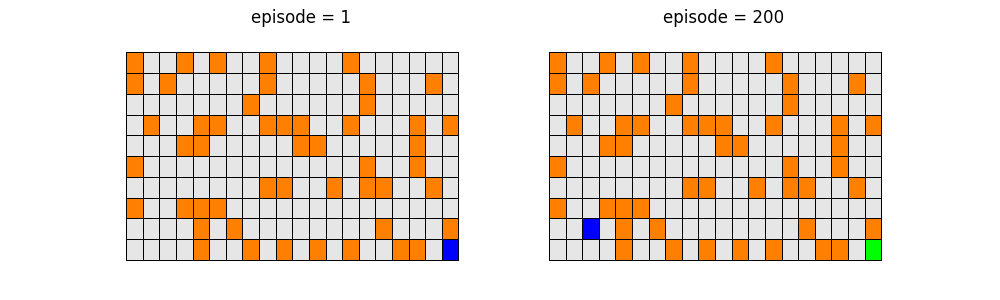
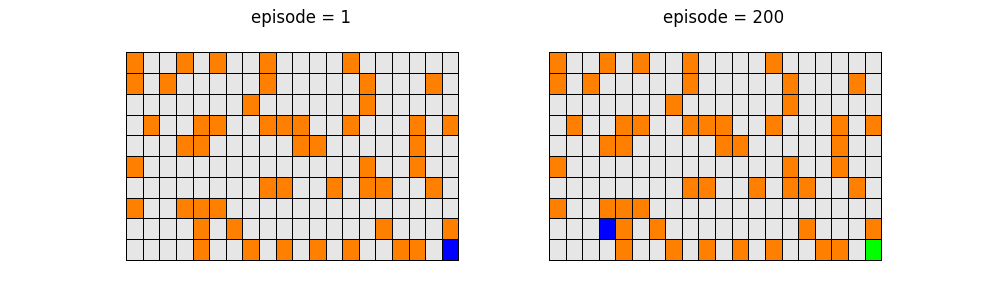
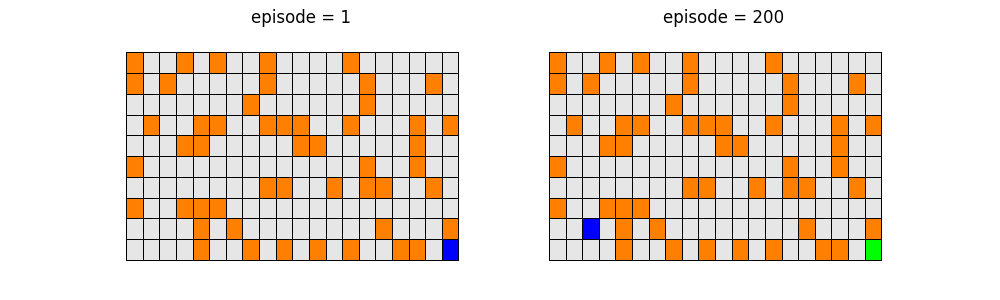
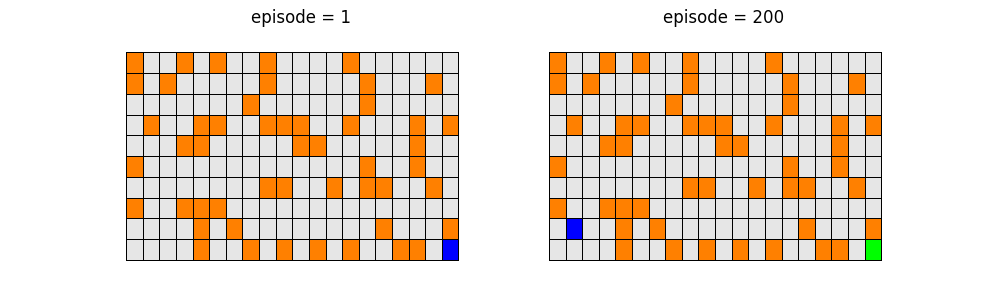
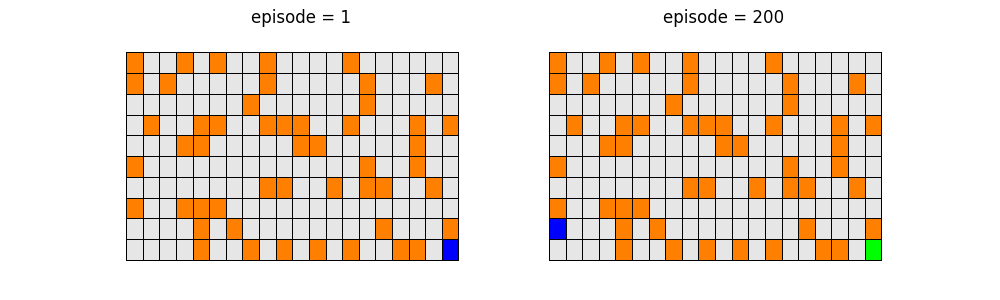
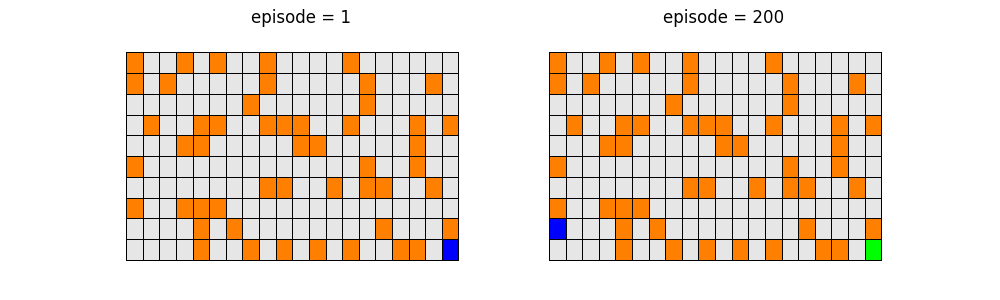
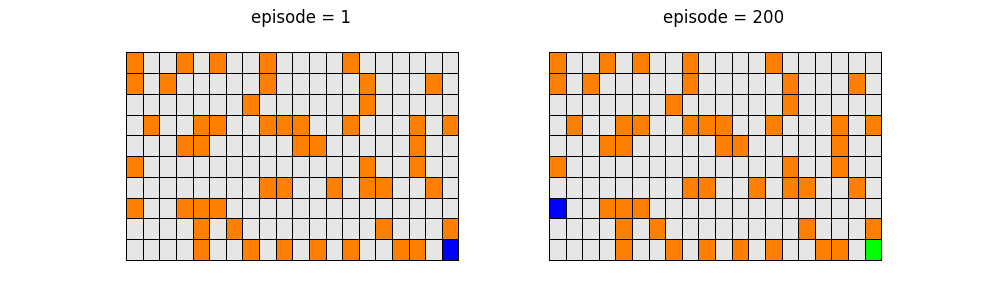
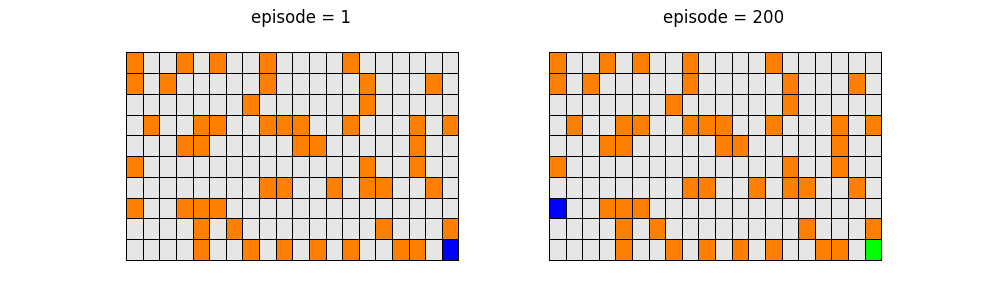
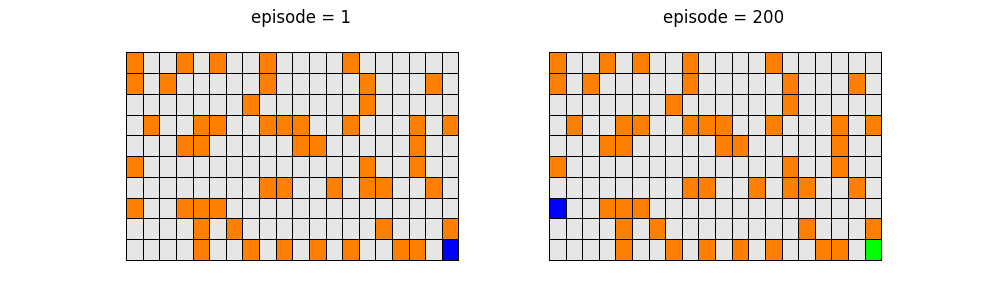
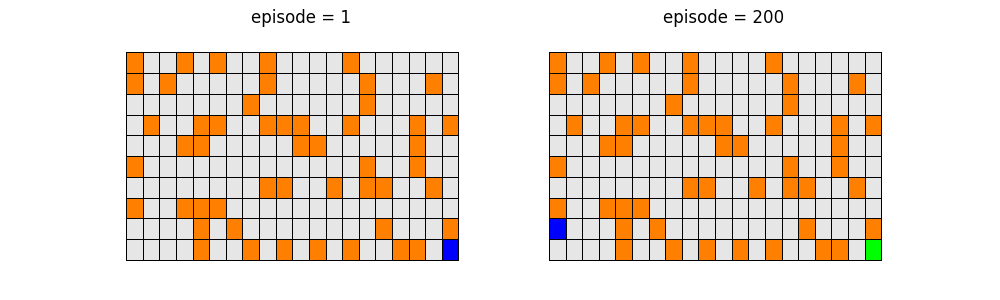
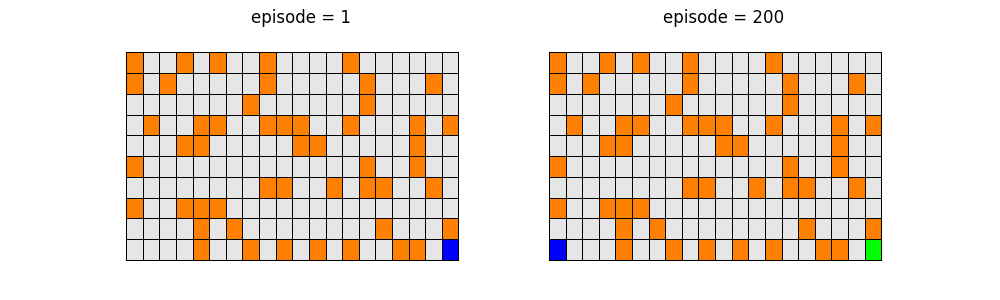
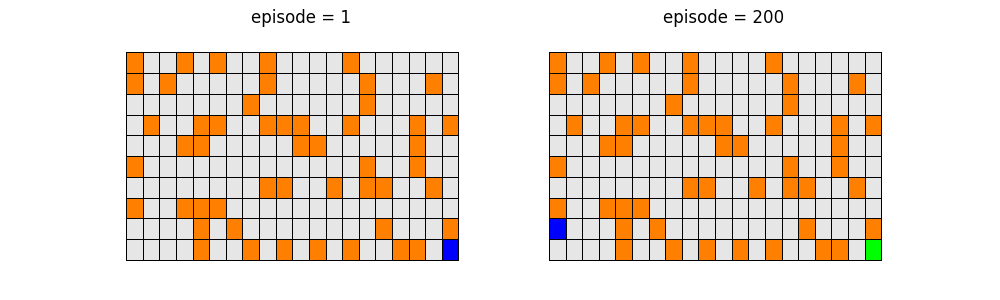
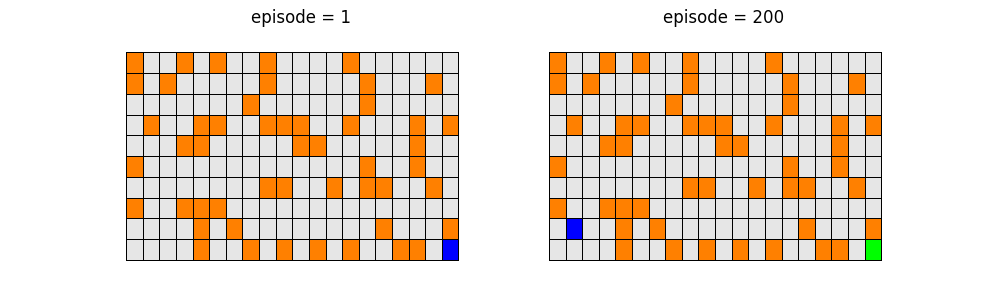
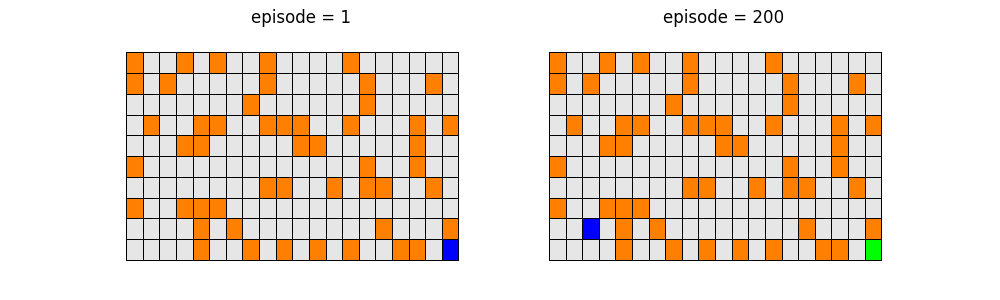
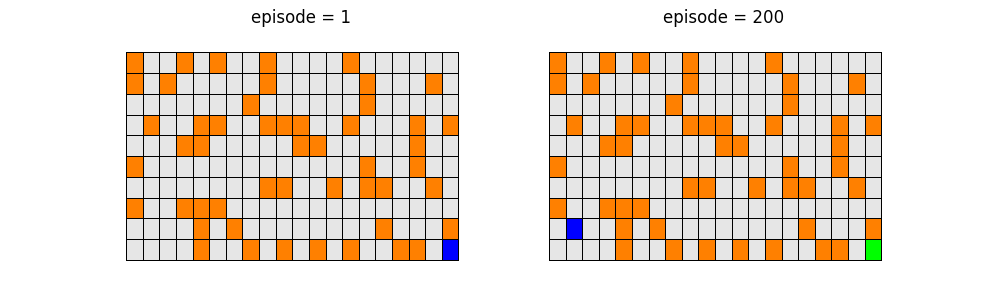
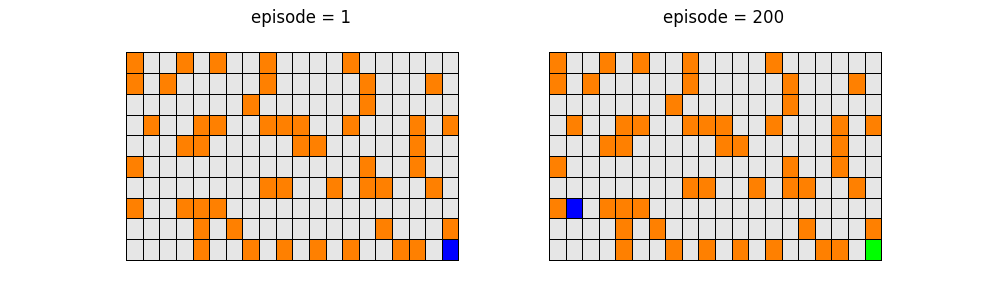
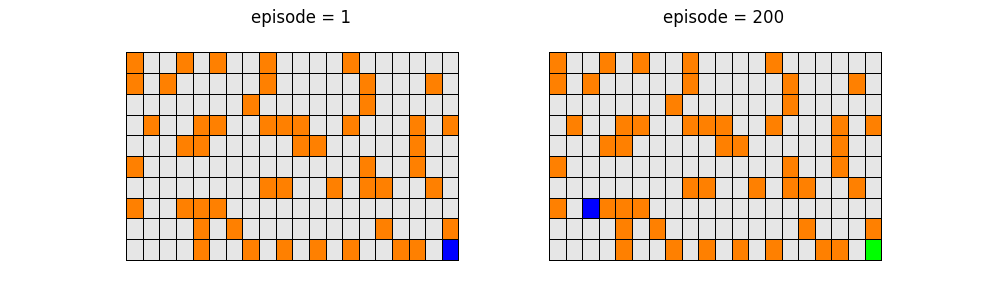
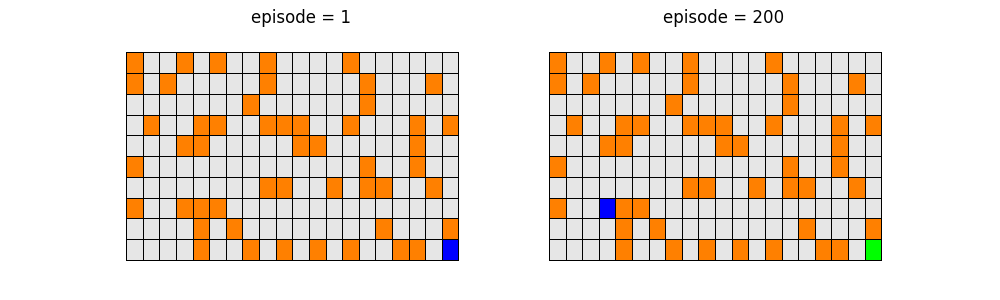
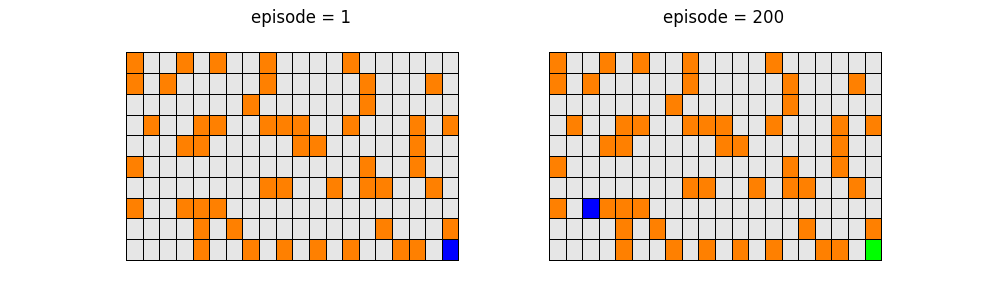
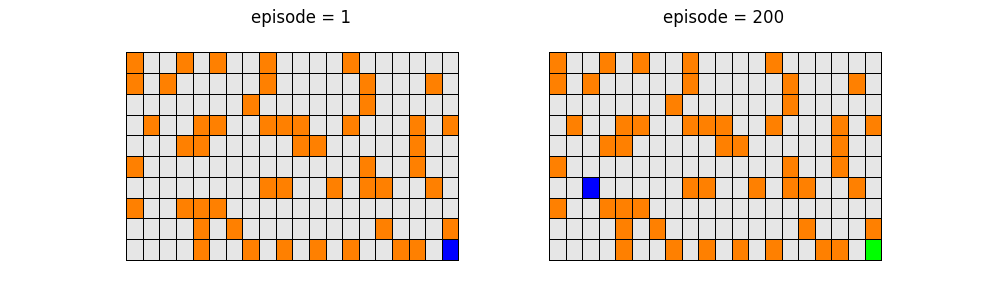
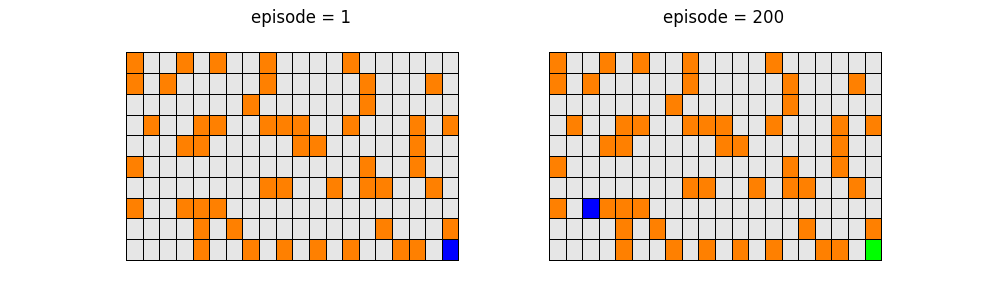
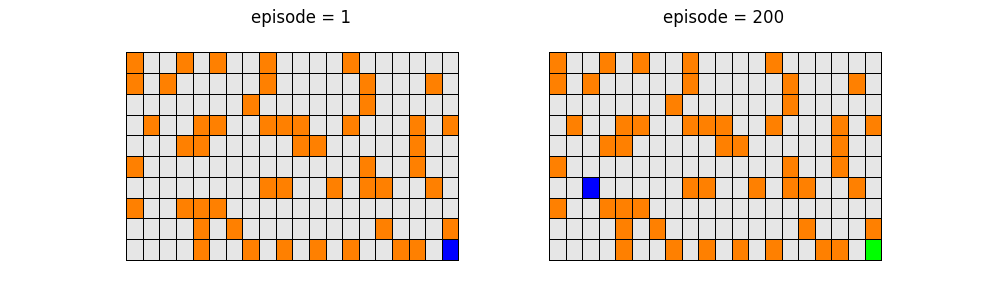
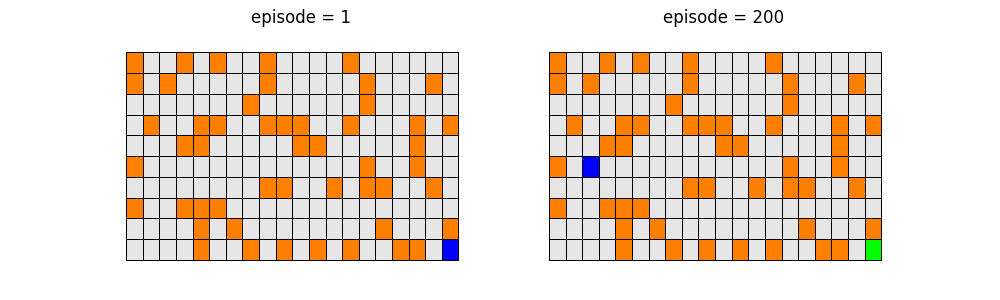
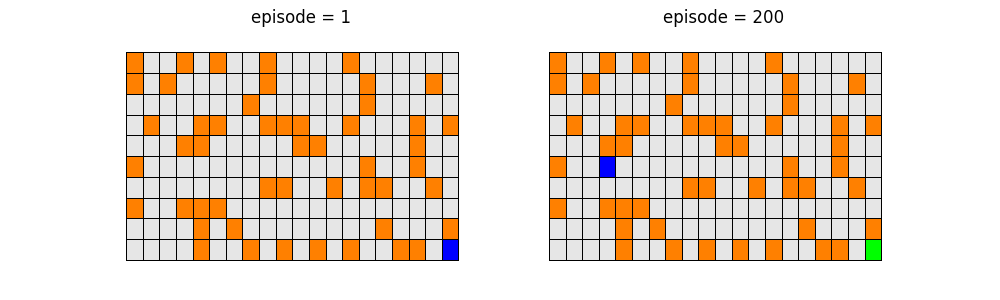
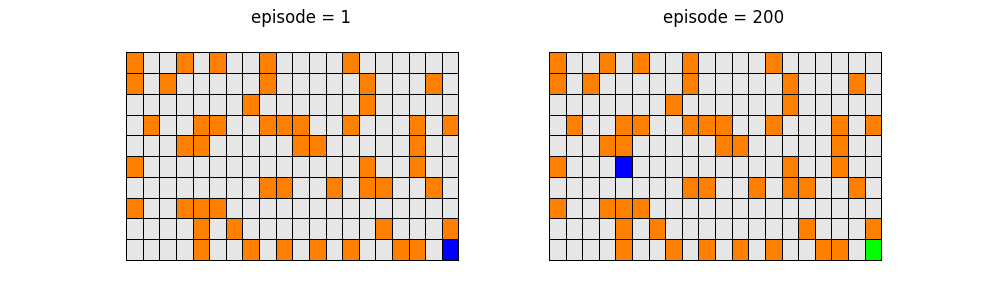
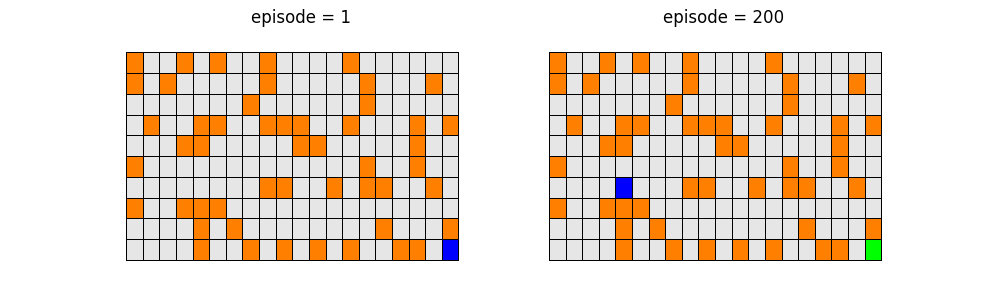
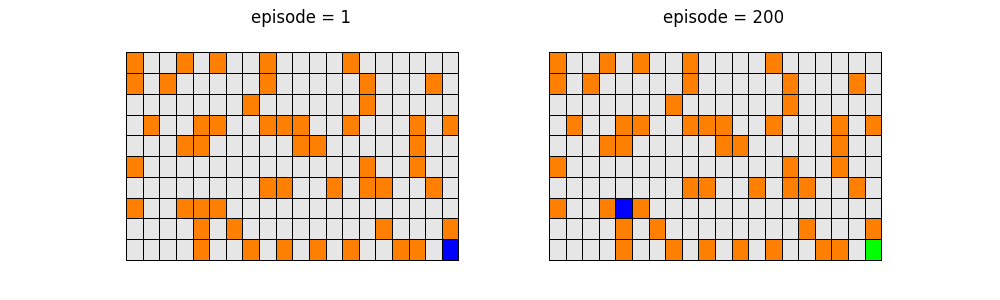
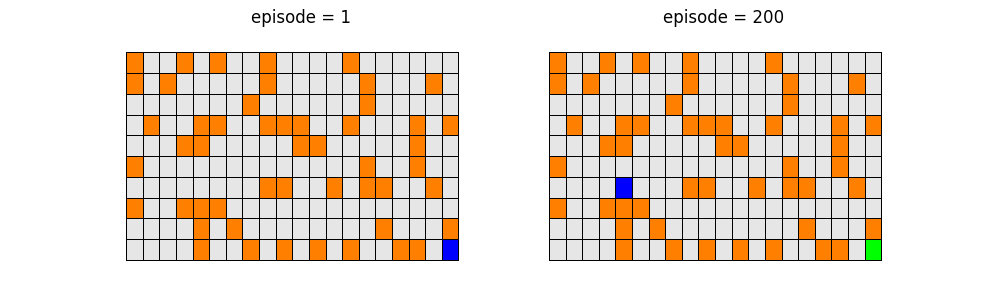
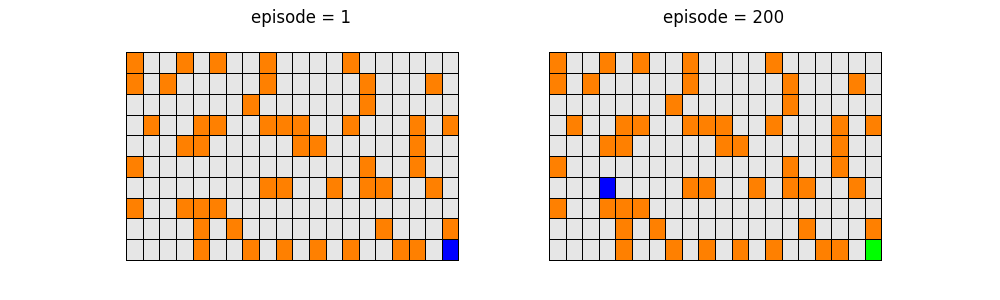
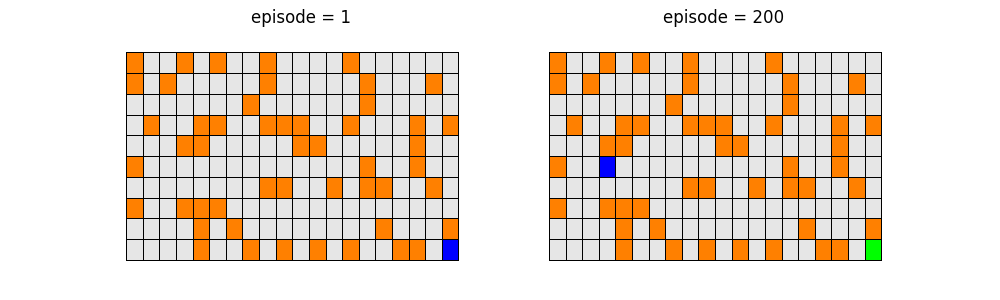
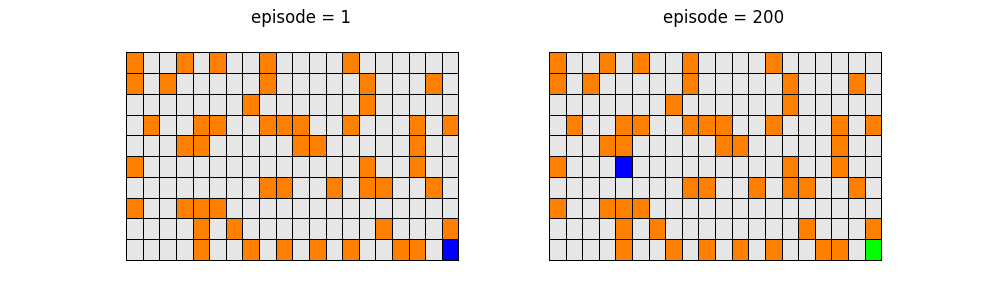
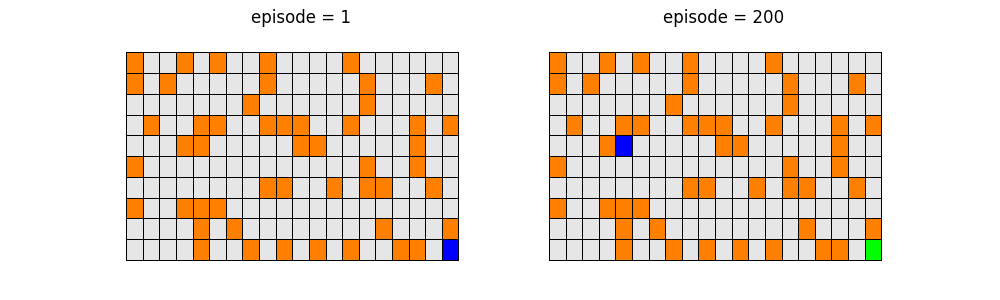
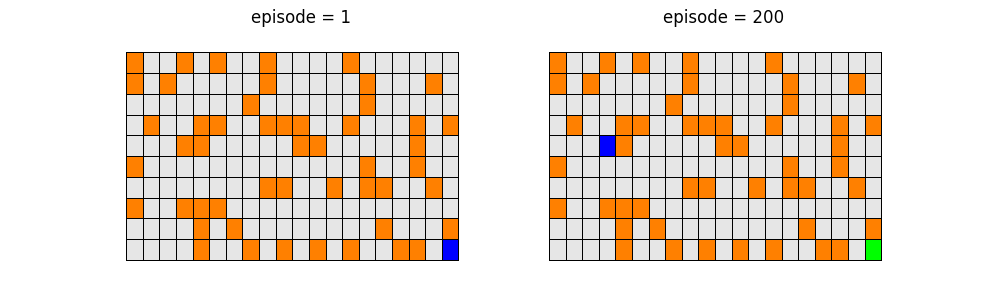
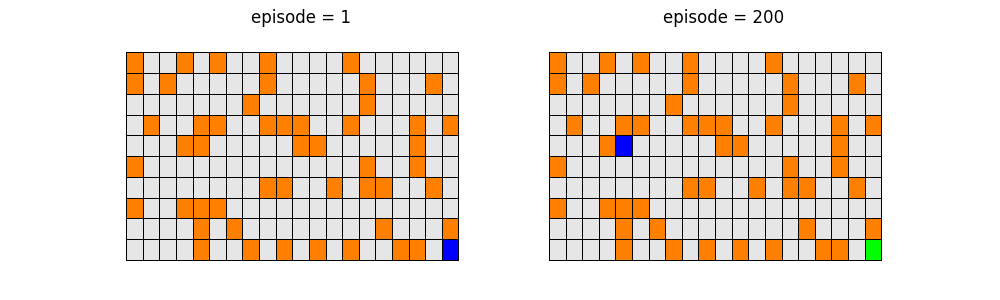
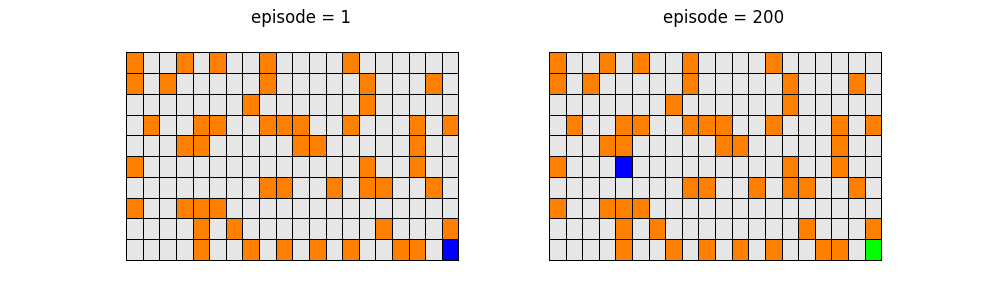
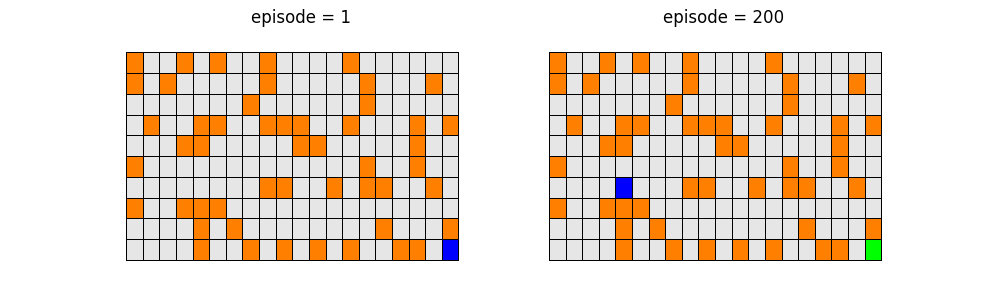
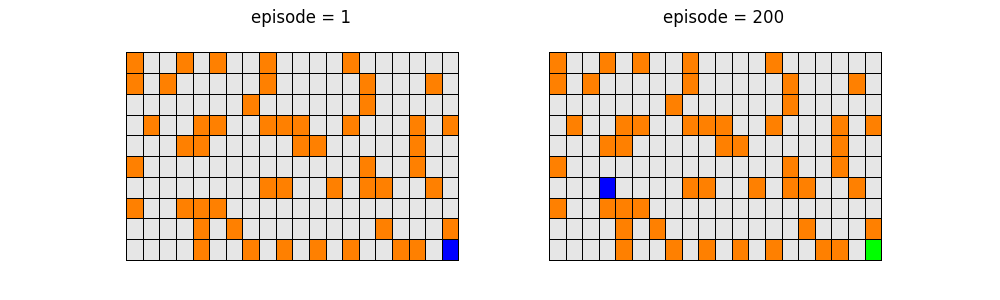
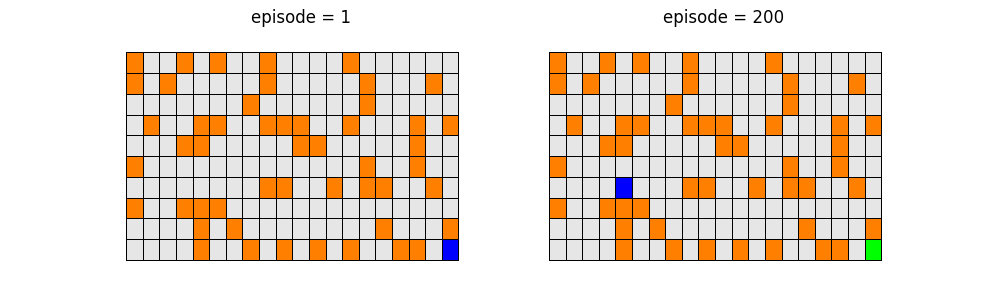
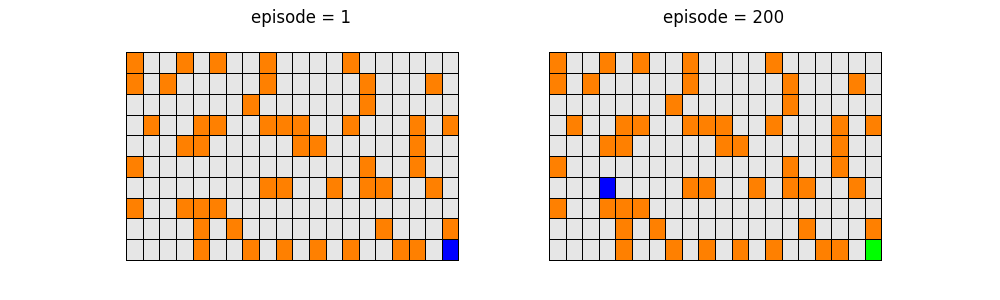
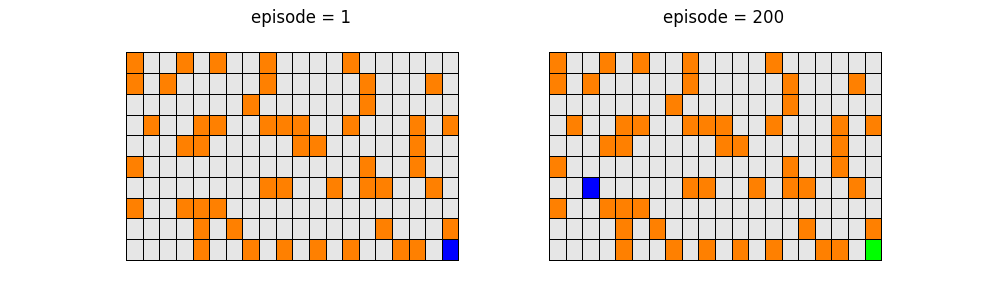
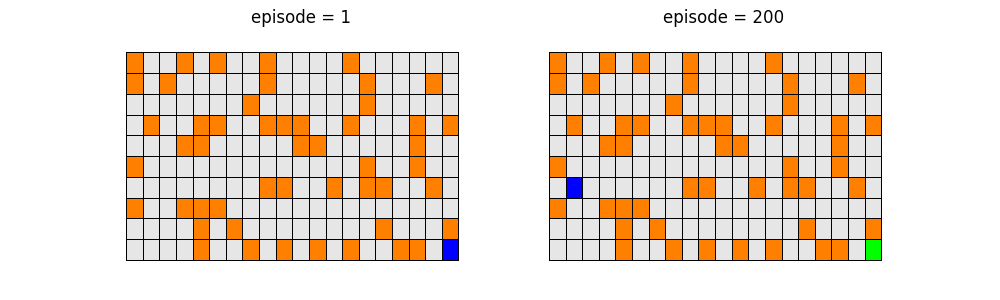
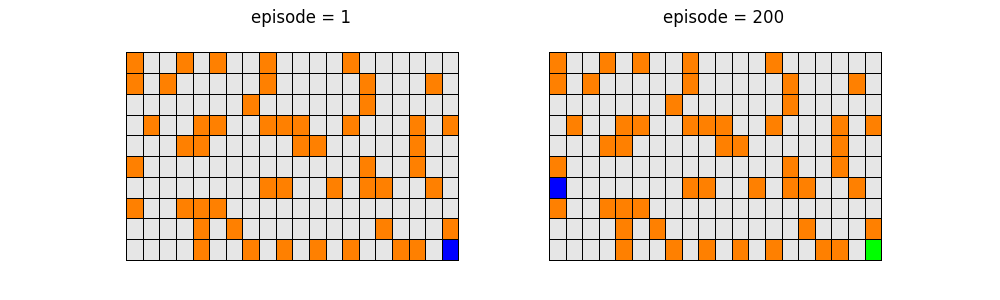
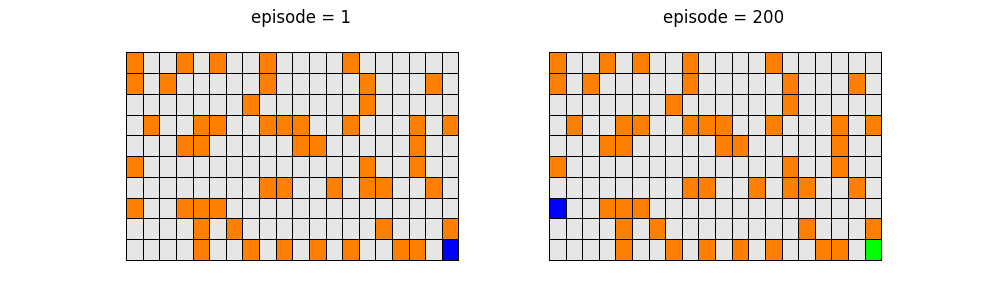
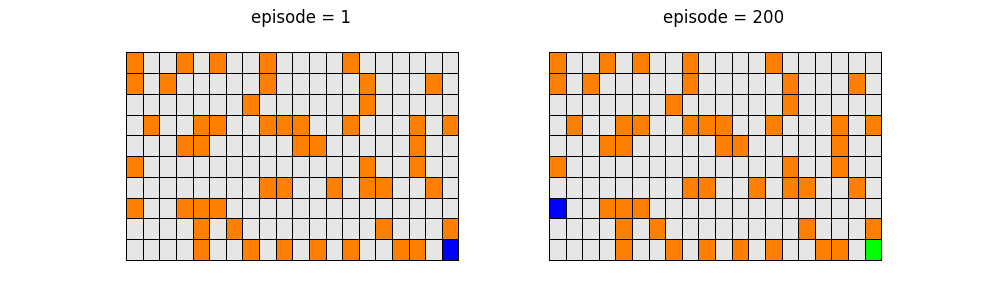

In [148]:
test.animate_single_version_training_episodes([0,training_episodes-1])


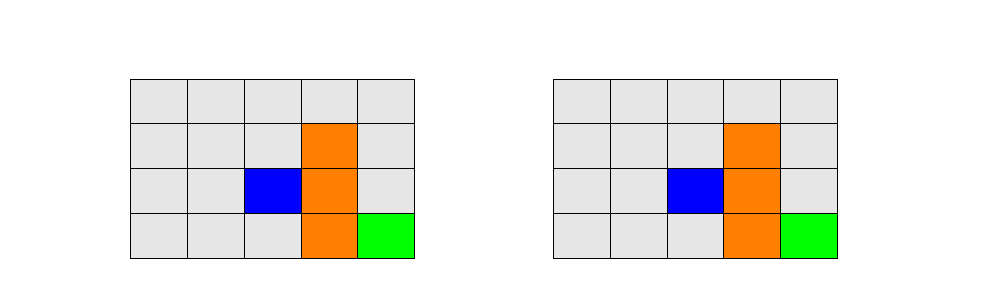
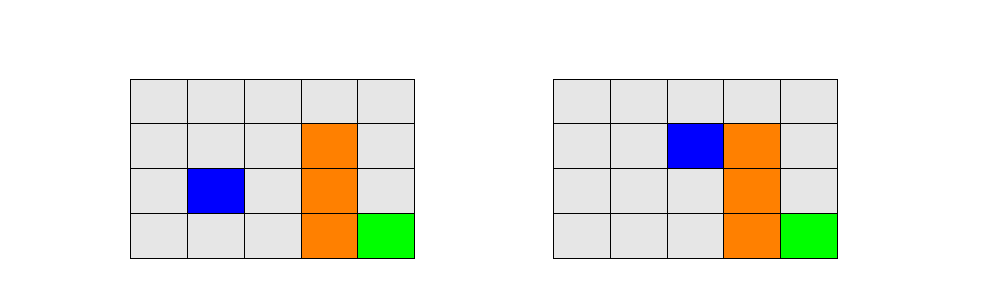
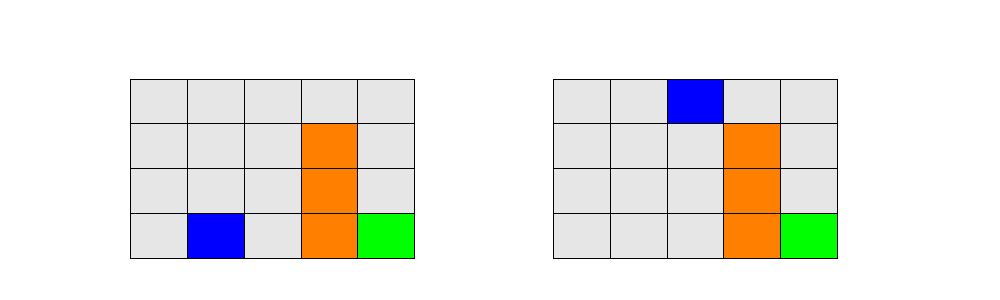
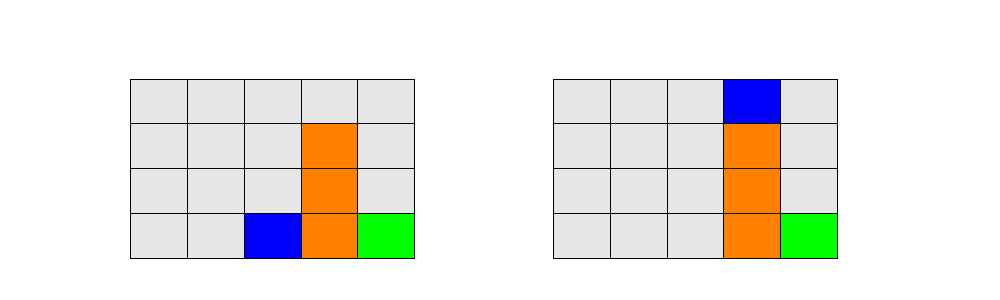
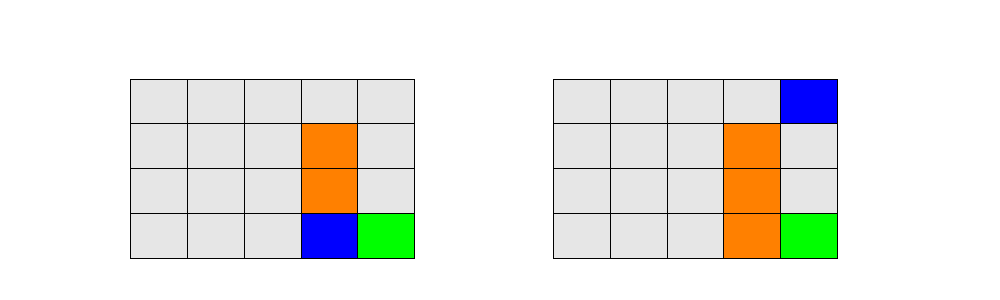
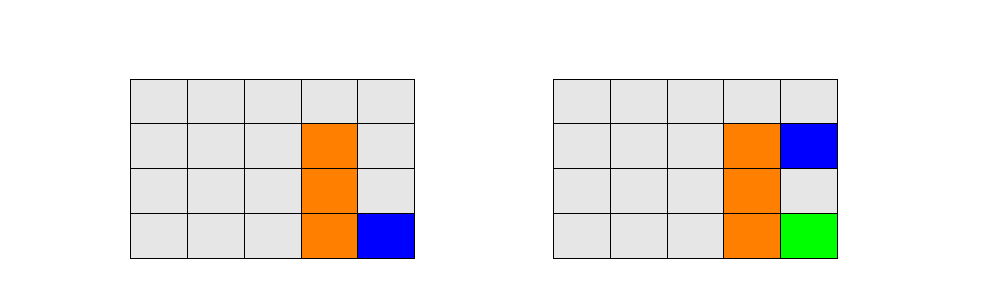
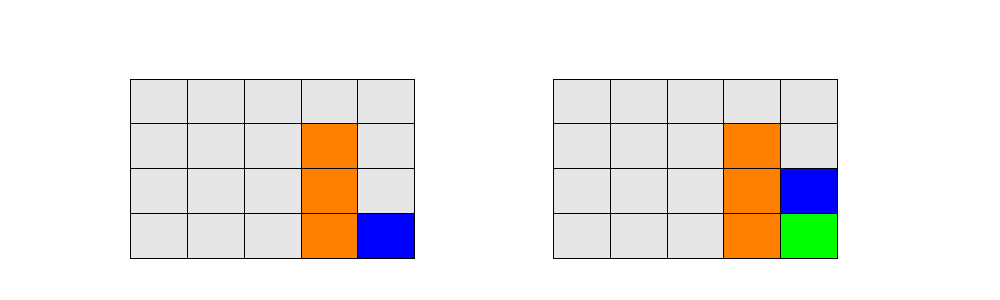
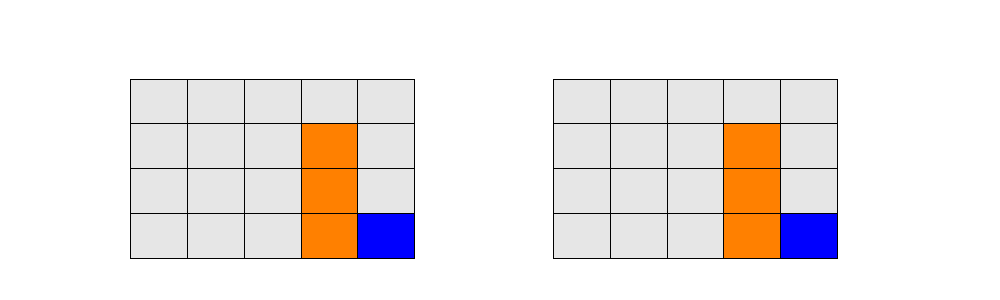

In [156]:
test.compare_v1v2_training_episode(test.training_episodes)

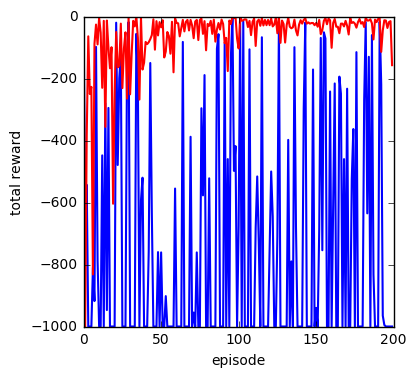

In [176]:
test.compare_v1v2_training_rewards()